In [1]:
import numpy as np
import time
import os
import lpr
import scipy as sp
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import arrayfire
import lpr_gpu
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.font_manager import FontProperties
import scipy.io as sio
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import interp1d
import matplotlib.animation as animation

plt.rcParams['animation.ffmpeg_path'] = 'D:/ffmpeg-20170706-3b3501f-win64-static/bin/ffmpeg'
font = FontProperties(fname=r"c:\windows\Fonts\SimSun.ttc", size=20)

In [2]:
def Conditional_Expectation(test_x, train_y, train_x):
    train_y_c = train_y - train_y.mean(axis = 0)
    train_x_c = train_x - train_x.mean(axis = 0)
    U_y, sigma_y, V_y = np.linalg.svd(train_y_c, full_matrices = 0)
    index_positive_y = (sigma_y > 0).sum()
    U_y, sigma_y, V_y = U_y[:, :index_positive_y], sigma_y[:index_positive_y], V_y[:index_positive_y]
    U_x, sigma_x, V_x = np.linalg.svd(train_x_c, full_matrices = 0)
    index_positive_x = (sigma_x > 0).sum()
    U_x, sigma_x, V_x = U_x[:, :index_positive_x], sigma_x[:index_positive_x], V_x[:index_positive_x]
    Sigma_y = np.zeros([index_positive_y, index_positive_y])
    Sigma_x = np.zeros([index_positive_x, index_positive_x])
    Lambda_x_inv = np.zeros([index_positive_x, index_positive_x])
    np.fill_diagonal(Sigma_y, sigma_y)
    np.fill_diagonal(Sigma_x, sigma_x)
    np.fill_diagonal(Lambda_x_inv, 1/sigma_x**2)
    scores_y = np.dot(U_y, Sigma_y)
    scores_x = np.dot(U_x, Sigma_x)
    y_pred = train_y.mean(axis = 0) + (V_y.T.dot(scores_y.T).dot(scores_x).dot(Lambda_x_inv).dot(V_x.dot((test_x - train_x.mean(axis = 0)).T))).T
    return(y_pred)

def Linear_Regression(test_x, train_y, train_x, n_day = 45, n_hour = 24):
    n_test = test_x.shape[0]
    n_grid = int(train_y.shape[1] / (n_day*n_hour))
    y_fit = np.empty(test_x.shape)
    y_fit[:] = np.nan
    for i in range(n_day*n_hour):
        y = train_y[:, n_grid*i:n_grid*(i+1)].reshape(-1)
        x = train_x[:, n_grid*i:n_grid*(i+1)].reshape(-1)
        test_x_part = test_x[:, n_grid*i:n_grid*(i+1)].reshape(-1)
        index_nan = np.where(np.isnan(y))
        y = np.delete(y, index_nan)
        x = np.delete(x, index_nan)
        X = np.vstack([np.ones(x.size), x]).T
        X_test_part = np.vstack([np.ones(test_x_part.size), test_x_part]).T
        y_fit[:, n_grid*i:n_grid*(i+1)] = X_test_part.dot(np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)).reshape(n_test, n_grid)
    return(y_fit)

def Predict_Error(y_pred, y_test, n_day = 45, n_hour = 24):
    n_test = y_test.shape[0]
    n_grid = int(y_test.shape[1] / (n_day*n_hour))
    absolute_error = abs(y_pred - y_test)
    daily_AE = np.empty([n_test, n_day])
    daily_AE[:] = np.nan
    for i in range(n_day):
        daily_AE[:, i] = np.nanmean(absolute_error[:, n_grid*n_hour*i:n_grid*n_hour*(i+1)], axis = 1)
    mean_daily_AE = daily_AE.mean(axis = 0)
    sd_daily_AE = daily_AE.std(axis = 0)
    return([mean_daily_AE, sd_daily_AE])

def Remove_out_of_bound(t_obs, temp_obs):
    for i in range(len(temp_obs)):
        temp_index = np.array(np.where((t_obs[i][:, 1] > 25.4) | (t_obs[i][:, 1] < 22) |
                                       (t_obs[i][:, 2] > 122) | (t_obs[i][:, 2] < 120) |
                                       ((t_obs[i][:, 1] > 23.2) & (t_obs[i][:, 1] < 23.6) &
                                        (t_obs[i][:, 2] > 120.8) & (t_obs[i][:, 2] < 121.2)) |
                                       ((t_obs[i][:, 1] > 25.14) & (t_obs[i][:, 1] < 25.4) &
                                        (t_obs[i][:, 2] > 121.4) & (t_obs[i][:, 2] < 121.6)) |
                                       ((t_obs[i][:, 1] > 22) & (t_obs[i][:, 1] < 22.2) &
                                        (t_obs[i][:, 2] > 121) & (t_obs[i][:, 2] < 121.6)) |
                                       ((t_obs[i][:, 1] < 24.8) & (t_obs[i][:, 2] > 121.2)) | 
                                       ((t_obs[i][:, 1] < 22.8) & (t_obs[i][:, 2] > 120.6)) |
                                       (np.isnan(temp_obs[i])))).reshape(-1)
        t_obs[i] = np.delete(t_obs[i], temp_index, 0)
        temp_obs[i] = np.delete(temp_obs[i], temp_index, 0)
    return([t_obs, temp_obs])

def Make_array(t_obs, temp_obs, grid_obs, n_day, n_hour=24):
    n_grid_obs = grid_obs.shape[0]
    temp_obs_array = np.empty([len(t_obs), n_day*n_hour, n_grid_obs])
    temp_obs_array[:] = np.nan
    for i in range(len(t_obs)):
        for j in range(n_day*n_hour):
            index_time = np.array(np.where(t_obs[i][:, 0] == np.unique(t_obs[i][:, 0])[j])).reshape(-1)
            for k in index_time:
                index_location = np.where((t_obs[i][k, -2:] == grid_obs).all(axis = 1))
                temp_obs_array[i][j, index_location] = temp_obs[i][k]
    return(temp_obs_array)

def Fit_nan(temp_obs, grid_obs, n_day, n_hour = 24):
    n_fn = temp_obs.shape[0]
    temp_obs_fit = np.empty(temp_obs.shape)
    temp_obs_fit[:] = temp_obs[:]
    for i in range(n_fn):
        for j in range(n_day*n_hour):
            index_nan = np.where(np.isnan(temp_obs_fit[i][j]))
            temp_obs_fit[i][j][index_nan] = lpr.Lpr(x = grid_obs, 
                                                    y = temp_obs[i][j], 
                                                    x0 = grid_obs[index_nan, :], 
                                                    h = np.array([0.4, 0.4]), 
                                                    ker_fun = 'Gaussian', 
                                                    binning = False)
    return(temp_obs_fit)

In [3]:
data = sio.loadmat('data.mat')
data_last_7days = sio.loadmat('data_last_7days.mat')
data_last_14days = sio.loadmat('data_last_14days.mat')
data_last_21days = sio.loadmat('data_last_21days.mat')
data_last_45days = sio.loadmat('data_last_45days.mat')
temp_forecast = data['temp_forecast']
t_forecast  = data['t_forecast']
time_index = data['time_index']
time_index_last_7days = data_last_7days['time_index_last_7days']
t_obs = []
temp_obs = []
t_obs_last_7days = []
t_obs_last_14days = []
t_obs_last_21days = []
t_obs_last_45days = []
temp_obs_last_7days = []
temp_obs_last_14days = []
temp_obs_last_21days = []
temp_obs_last_45days = []
for i in range(len(data['t_obs'][0])):
    t_obs.append(data['t_obs'][0][i])
    temp_obs.append(data['temp_obs'][0][i][0])
    t_obs_last_7days.append(data_last_7days['t_obs_last_7days'][0][i])
    temp_obs_last_7days.append(data_last_7days['temp_obs_last_7days'][0][i][0])
    t_obs_last_14days.append(data_last_14days['t_obs_last_14days'][0][i])
    temp_obs_last_14days.append(data_last_14days['temp_obs_last_14days'][0][i][0])
    t_obs_last_21days.append(data_last_21days['t_obs_last_21days'][0][i])
    temp_obs_last_21days.append(data_last_21days['temp_obs_last_21days'][0][i][0])
    t_obs_last_45days.append(data_last_45days['t_obs_last_45days'][0][i])
    temp_obs_last_45days.append(data_last_45days['temp_obs_last_45days'][0][i][0])

In [4]:
t_obs, temp_obs = Remove_out_of_bound(t_obs, temp_obs)
t_obs_last_7days, temp_obs_last_7days = Remove_out_of_bound(t_obs_last_7days, temp_obs_last_7days)
t_obs_last_14days, temp_obs_last_14days = Remove_out_of_bound(t_obs_last_14days, temp_obs_last_14days)
t_obs_last_21days, temp_obs_last_21days = Remove_out_of_bound(t_obs_last_21days, temp_obs_last_21days)
t_obs_last_45days, temp_obs_last_45days = Remove_out_of_bound(t_obs_last_45days, temp_obs_last_45days)
grid_obs = np.vstack({tuple(row) for row in np.vstack(t_obs)[:, -2:]})

In [5]:
#settings of grid

n_grid_obs = grid_obs.shape[0]
n_day, n_hour = 45, 24

In [ ]:
pre_time = time.time()
temp_obs_array = Make_array(t_obs, temp_obs, grid_obs, n_day)
temp_obs_last_7days_array = Make_array(t_obs_last_7days, temp_obs_last_7days, grid_obs, 7)
temp_obs_last_14days_array = Make_array(t_obs_last_14days, temp_obs_last_14days, grid_obs, 14)
temp_obs_last_21days_array = Make_array(t_obs_last_21days, temp_obs_last_21days, grid_obs, 21)
time.time() - pre_time

In [ ]:
pre_time = time.time()
temp_obs_last_45days_array = Make_array(t_obs_last_45days[1:], temp_obs_last_45days[1:], grid_obs, 45)
time.time() - pre_time

In [ ]:
os.chdir('/Users/Power/workspace/')
np.save('temp_obs_array', temp_obs_array)
np.save('temp_obs_last_7days_array', temp_obs_last_7days_array)
np.save('temp_obs_last_14days_array', temp_obs_last_14days_array)
np.save('temp_obs_last_21days_array', temp_obs_last_21days_array)

In [ ]:
np.save('temp_obs_last_45days_array', temp_obs_last_45days_array)

In [6]:
temp_obs_array = np.load('temp_obs_array.npy')
temp_obs_last_7days_array = np.load('temp_obs_last_7days_array.npy')
temp_obs_last_14days_array = np.load('temp_obs_last_14days_array.npy')
temp_obs_last_21days_array = np.load('temp_obs_last_21days_array.npy')
temp_obs_last_45days_array = np.load('temp_obs_last_45days_array.npy')

In [7]:
location_name = np.array([[24.9, 121.031, '新竹湖口'], [24.753201, 121.7461, '宜蘭'], [24.8647, 121.208, '桃園平鎮'], 
                          [24.6, 121.8667, '宜蘭蘇澳'], [24.766701, 121.75, '宜蘭'], [24.8167, 121, '新竹'], 
                          [24.9842, 121.4442, '新北板橋'], [24.9547, 121.2136, '桃園八德'], [24.7414, 121.0803, '新竹橫山'], 
                          [24.958, 121.2042, '桃園龍潭'], [24.9788, 121.529, '台北'], [24.995899, 121.3136, '桃園'], 
                          [24.633301, 121.7857, '宜蘭冬山'], [25.041401, 121.0725, '桃園新屋'], [23.1, 121.3667, '台東成功'], 
                          [23.9333, 121.6, '花蓮'], [23.9729, 121.5915, '花蓮'], [22.995001, 120.197, '台南'], 
                          [22.5667, 120.3, '高雄'], [22.35, 120.9, '台東大溪山'], [22, 120.7333, '屏東恆春'], 
                          [22.8867, 120.5256, '屏東高樹'], [22.6882, 120.3283, '高雄仁武'], [22.606001, 120.3005, '高雄苓雅'], 
                          [22.628799, 120.3497, '高雄鳳山'], [22.632999, 120.2791, '高雄新興'], [22.9858, 120.2266, '台南仁德'], 
                          [23.466, 120.2389, '嘉義朴子'], [23.711599, 120.5359, '雲林斗六'], [23.5564, 120.3372, '嘉義新港'], 
                          [23.5, 120.4167, '嘉義'], [23.1467, 120.086, '台南七股'], [23.03944, 120.2286, '台南永康'], 
                          [23.753506, 120.25182, '雲林麥寮'], [23.7596, 120.345, '雲林崙背'], [23.473101, 120.4307, '嘉義'], 
                          [23.307301, 120.3084, '台南新營'], [23.0494, 120.2092, '台南永康'], [23.926201, 120.4015, '彰化福興'], 
                          [24.808599, 120.9609, '新竹市東'], [24.1008, 120.6706, '台中烏日'], [24.68638, 120.89167, '苗栗頭份'], 
                          [24.131201, 120.4626, '彰化伸港'], [23.704901, 120.204, '雲林東勢'], [22.7586, 120.2978, '高雄橋頭'], 
                          [22.4814, 120.4034, '屏東南州'], [22.733299, 120.3189, '高雄大社'], [22.679199, 120.2865, '高雄左營'], 
                          [22.566401, 120.4167, '屏東新園'], [22.674101, 120.4804, '屏東'], [22.567801, 120.3344, '高雄'], 
                          [22.513, 120.529, '屏東潮州'], [23.114599, 120.2889, '台南善化'], [22.6103, 120.3033, '高雄三民'], 
                          [25.133301, 121.7333, '基隆'], [25.0686, 121.6469, '新北汐止'], [25.181, 121.681, '新北金山'], 
                          [25.0783, 121.3683, '新北林口'], [25.116699, 121.73, '基隆'], [25.083, 121.2069, '桃園埔心'], 
                          [24.1472, 120.6834, '台中南屯'], [24.2652, 120.5312, '台中梧棲'], [24.3832, 120.7508, '台中后里'], 
                          [24.2271, 120.5482, '台中龍井'], [24.6863, 120.8917, '苗栗竹南'], [24.162901, 120.6093, '台中大雅'], 
                          [24.0833, 120.5389, '彰化彰師大'], [24.566299, 120.8119, '苗栗'], [24.2491, 120.7058, '台中豐原'], 
                          [24.159401, 120.6506, '台中西屯'], [22.6481, 120.3011, '高雄三民'], [25.080601, 121.2261, '桃園蘆竹'], 
                          [25.063801, 121.5049, '台北大直'], [23.970301, 120.9594, '南投埔里'], [22.75, 121.15, '台東'], 
                          [22.756001, 121.1422, '台東'], [25.0359, 121.5053, '台北'], [25.063601, 121.5179, '台北大直'], 
                          [25.035601, 121.4247, '新北新莊'], [23.903299, 120.68, '南投'], [23.758301, 120.6692, '南投竹山'], 
                          [23.880301, 120.9, '南投魚池'], [23.516701, 120.8, '嘉義阿里山'], [25.064199, 121.4807, '新北三重'], 
                          [25.018299, 121.5078, '台北'], [25.0137, 121.4499, '新北永和'], [25.051901, 121.57, '台北松山'], 
                          [25.074699, 121.4867, '新北蘆洲'], [25.1068, 121.5065, '台北石牌'], [25.030001, 121.4906, '新北永和']])

In [8]:
temp_obs = np.delete(temp_obs_array, 88, axis = 0)
temp_obs_last_7days = np.delete(temp_obs_last_7days_array, 88, axis = 0)
temp_obs_last_14days = np.delete(temp_obs_last_14days_array, 88, axis = 0)
temp_obs_last_21days = np.delete(temp_obs_last_21days_array, 88, axis = 0)
temp_obs_last_45days = np.delete(temp_obs_last_45days_array, 87, axis = 0)
temp_forecast = np.delete(temp_forecast, 88, axis = 0)
t_obs = np.hstack((np.repeat(np.unique(t_obs[0][:, 0]), n_grid_obs).reshape(-1, 1), np.tile(grid_obs, (n_day*n_hour, 1))))
t_obs_last_7days = np.hstack((np.repeat(np.unique(t_obs_last_7days[0][:, 0]), n_grid_obs).reshape(-1, 1), np.tile(grid_obs, (7*n_hour, 1))))
t_obs_last_14days = np.hstack((np.repeat(np.unique(t_obs_last_14days[0][:, 0]), n_grid_obs).reshape(-1, 1), np.tile(grid_obs, (14*n_hour, 1))))
t_obs_last_21days = np.hstack((np.repeat(np.unique(t_obs_last_21days[0][:, 0]), n_grid_obs).reshape(-1, 1), np.tile(grid_obs, (21*n_hour, 1))))
t_obs_last_45days = np.hstack((np.repeat(np.unique(t_obs_last_45days[1][:, 0]), n_grid_obs).reshape(-1, 1), np.tile(grid_obs, (45*n_hour, 1))))

In [9]:
n_test = 23
test_temp_obs = temp_obs_array[-n_test:]
test_temp_obs_last_7days = temp_obs_last_7days_array[-n_test:]
test_temp_obs_last_14days = temp_obs_last_14days_array[-n_test:]
test_temp_obs_last_21days = temp_obs_last_21days_array[-n_test:]
test_temp_obs_last_45days = temp_obs_last_45days_array[-n_test:]
test_temp_forecast = temp_forecast[-n_test:]
test_time_index = time_index[-n_test:]
test_time_index_last_7days = time_index_last_7days[-n_test:]
n_fn = temp_obs.shape[0]
n_train = n_fn - n_test

In [10]:
n_test, n_train

(23, 188)

D:\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3274: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
D:\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3283: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


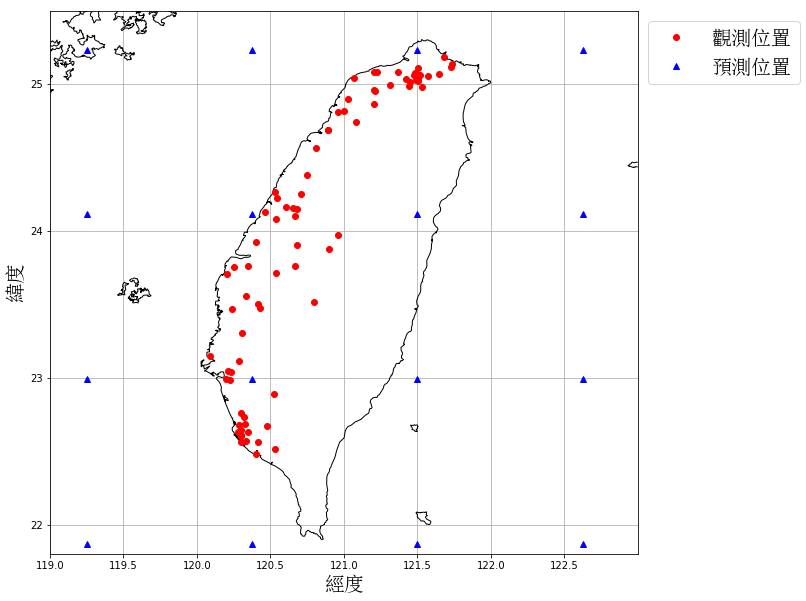

In [11]:
fig = plt.figure(figsize = (15, 10))
map1 = Basemap(llcrnrlon = 119, llcrnrlat = 21.8, urcrnrlon = 123, urcrnrlat = 25.5, 
               resolution = 'h', lat_0 = 23.5, lon_0 = 120.5)
map1.plot(grid_obs[:, 1], grid_obs[:, 0], 'or', label = '觀測位置')
map1.plot(t_forecast[:16, 2], t_forecast[:16, 1], '^b', label = '預測位置')
map1.drawcoastlines()
plt.xticks(np.arange(119, 123, 0.5))
plt.yticks(np.arange(22, 25.5, 1))
plt.legend(bbox_to_anchor=(1, 1), loc=2, prop = font)
plt.grid(True)
plt.xlabel('經度', fontproperties = font)
plt.ylabel('緯度', fontproperties = font)
fig.savefig('grid.png')
plt.show()

In [12]:
n_grid_obs

79

In [ ]:
lpr_gpu.Set_arrayfire_backend('cpu')

In [13]:
pre_time = time.time()
temp_obs_fit = Fit_nan(temp_obs, grid_obs, n_day)
temp_obs_last_7days_fit = Fit_nan(temp_obs_last_7days, grid_obs, 7)
temp_obs_last_14days_fit = Fit_nan(temp_obs_last_14days, grid_obs, 14)
temp_obs_last_21days_fit = Fit_nan(temp_obs_last_21days, grid_obs, 21)
temp_obs_last_45days_fit = Fit_nan(temp_obs_last_45days, grid_obs, 45)
time.time() - pre_time

477.80281829833984

In [14]:
#conditional expectation to predict 45 days temperature

pre_time = time.time()
temp_pred = np.empty([n_test, n_day*n_hour*n_grid_obs])
temp_pred[:] = np.nan
for i in range(n_test):
    temp_pred[i] = Conditional_Expectation(test_temp_forecast[i].reshape(1, -1), 
                                           temp_obs_fit[:n_train+i-1].reshape(n_train+i-1, -1), 
                                           temp_forecast[:n_train+i-1])
time.time() - pre_time

182.4911985397339

In [15]:
#conditional expectation to predict 45 days temperature(2 covariates:forecast + last 7 days)

pre_time = time.time()
temp_pred2 = np.empty([n_test, n_day*n_hour*n_grid_obs])
temp_pred2[:] = np.nan
for i in range(n_test):
    temp_pred2[i] = Conditional_Expectation(np.hstack((test_temp_forecast[i].reshape(1, -1), temp_obs_last_7days_fit[n_train+i].reshape(1, -1))), 
                                            temp_obs_fit[:n_train+i-1].reshape(n_train+i-1, -1), 
                                            np.hstack((temp_forecast, temp_obs_last_7days_fit.reshape(n_fn, -1)))[:n_train+i-1])
time.time() - pre_time

201.71373891830444

In [16]:
#conditional expectation to predict 45 days temperature(2 covariates:forecast + last 14 days)

pre_time = time.time()
temp_pred3 = np.empty([n_test, n_day*n_hour*n_grid_obs])
temp_pred3[:] = np.nan
for i in range(n_test):
    temp_pred3[i] = Conditional_Expectation(np.hstack((test_temp_forecast[i].reshape(1, -1), temp_obs_last_14days_fit[n_train+i].reshape(1, -1))), 
                                            temp_obs_fit[:n_train+i-1].reshape(n_train+i-1, -1), 
                                            np.hstack((temp_forecast, temp_obs_last_14days_fit.reshape(n_fn, -1)))[:n_train+i-1])
time.time() - pre_time

224.25044775009155

In [17]:
#conditional expectation to predict 45 days temperature(2 covariates:forecast + last 21 days)

pre_time = time.time()
temp_pred4 = np.empty([n_test, n_day*n_hour*n_grid_obs])
temp_pred4[:] = np.nan
for i in range(n_test):
    temp_pred4[i] = Conditional_Expectation(np.hstack((test_temp_forecast[i].reshape(1, -1), temp_obs_last_21days_fit[n_train+i].reshape(1, -1))), 
                                            temp_obs_fit[:n_train+i-1].reshape(n_train+i-1, -1), 
                                            np.hstack((temp_forecast, temp_obs_last_21days_fit.reshape(n_fn, -1)))[:n_train+i-1])
time.time() - pre_time

244.24677395820618

In [18]:
#conditional expectation to predict 45 days temperature(2 covariates:forecast + last 45 days)

pre_time = time.time()
temp_pred5 = np.empty([n_test, n_day*n_hour*n_grid_obs])
temp_pred5[:] = np.nan
for i in range(n_test):
    temp_pred5[i] = Conditional_Expectation(np.hstack((test_temp_forecast[i].reshape(1, -1), temp_obs_last_45days_fit[n_train+i-1].reshape(1, -1))), 
                                            temp_obs_fit[1:n_train+i-1].reshape(n_train+i-2, -1), 
                                            np.hstack((temp_forecast[1:], temp_obs_last_45days_fit.reshape(n_fn-1, -1)))[:n_train+i-2])
time.time() - pre_time

316.04990124702454

In [19]:
#temp_forecast 對時間內插

pre_time = time.time()
temp_forecast_interp_t = np.empty([n_fn, n_day*n_hour, 16])
temp_forecast_interp_t[:] = np.nan
for i in range(n_fn):
    for j in range(16):
        Linear_Interp = interp1d(np.unique(t_forecast[:, 0]),
                                 temp_forecast.reshape(n_fn, 4*n_day+1, -1)[i][:, j])
        temp_forecast_interp_t[i][:, j] = Linear_Interp(np.unique(t_obs[:, 0]))
time.time() - pre_time

4.007659673690796

In [20]:
#temp_forecast_interp_t 對空間內插

pre_time = time.time()
temp_forecast_interp = np.empty([n_fn, n_day*n_hour, n_grid_obs])
temp_forecast_interp[:] = np.nan
for i in range(n_fn):
    for j in range(n_day*n_hour):
        Linear_Interp = LinearNDInterpolator(t_forecast[:16, -2:], 
                                             temp_forecast_interp_t[i][j])
        temp_forecast_interp[i][j] = Linear_Interp(grid_obs)
temp_forecast_interp = temp_forecast_interp.reshape(n_fn, -1)
time.time() - pre_time

275.215856552124

In [21]:
test_temp_forecast_interp = temp_forecast_interp[n_train:]

In [22]:
#linear regression to predict 45 days temperatre

pre_time = time.time()
temp_pred_lm = np.empty([n_test, n_day*n_hour*n_grid_obs])
temp_pred_lm[:] = np.nan
for i in range(n_test):
    temp_pred_lm[i] = Linear_Regression(test_temp_forecast_interp[i].reshape(1, -1), 
                                        temp_obs[:n_train+i-1].reshape(n_train+i-1, -1), 
                                        temp_forecast_interp[:n_train+i-1])
time.time() - pre_time

14.051422595977783

In [23]:
mean_daily_AE, sd_daily_AE = Predict_Error(temp_pred, test_temp_obs.reshape(n_test, -1))
mean_daily_AE_forecast, sd_daily_AE_forecast = Predict_Error(test_temp_forecast_interp, test_temp_obs.reshape(n_test, -1))
mean_daily_AE_lm, sd_daily_AE_lm = Predict_Error(temp_pred_lm, test_temp_obs.reshape(n_test, -1))
mean_daily_AE_7days, sd_daily_AE_7days = Predict_Error(temp_pred2, test_temp_obs.reshape(n_test, -1))
mean_daily_AE_14days, sd_daily_AE_14days = Predict_Error(temp_pred3, test_temp_obs.reshape(n_test, -1))
mean_daily_AE_21days, sd_daily_AE_21days = Predict_Error(temp_pred4, test_temp_obs.reshape(n_test, -1))
mean_daily_AE_45days, sd_daily_AE_45days = Predict_Error(temp_pred5, test_temp_obs.reshape(n_test, -1))

In [ ]:
#daily_AE

mean_daily_AE, sd_daily_AE

In [24]:
np.round(mean_daily_AE, 2)

array([ 1.76,  1.91,  1.85,  1.92,  1.93,  1.96,  2.33,  2.34,  2.31,
        2.29,  2.3 ,  2.71,  3.07,  3.13,  2.96,  2.89,  2.42,  2.47,
        2.41,  2.44,  2.22,  2.43,  2.42,  2.6 ,  2.48,  2.53,  2.57,
        2.83,  2.83,  2.67,  2.34,  2.33,  2.47,  2.64,  3.  ,  2.82,
        2.65,  2.65,  2.59,  2.44,  2.4 ,  2.67,  2.89,  3.03,  2.87])

In [ ]:
#daily_AE_forecast

mean_daily_AE_forecast, sd_daily_AE_forecast

In [25]:
np.round(mean_daily_AE_forecast, 2)

array([ 2.48,  2.68,  2.81,  2.9 ,  3.05,  2.94,  3.29,  3.35,  3.38,
        3.4 ,  3.19,  3.03,  3.45,  3.6 ,  3.58,  3.35,  3.4 ,  3.35,
        3.24,  3.32,  3.48,  3.48,  3.36,  3.32,  3.08,  3.16,  3.02,
        3.31,  3.38,  3.27,  3.44,  3.67,  3.66,  3.79,  3.79,  3.64,
        3.29,  3.1 ,  3.27,  3.39,  3.55,  3.96,  3.94,  4.15,  4.18])

In [ ]:
#daily_AE_lm

mean_daily_AE_lm, sd_daily_AE_lm

In [26]:
np.round(mean_daily_AE_lm, 2)

array([ 1.92,  2.05,  2.15,  2.11,  2.3 ,  2.28,  2.57,  2.65,  2.73,
        2.76,  2.5 ,  2.65,  3.16,  3.26,  3.31,  3.11,  2.93,  2.76,
        2.76,  2.73,  2.77,  2.89,  2.67,  2.63,  2.59,  2.66,  2.74,
        3.1 ,  3.14,  2.88,  3.06,  3.03,  3.16,  3.42,  3.43,  3.13,
        2.76,  2.54,  2.73,  2.93,  3.03,  3.36,  3.54,  3.83,  3.85])

In [ ]:
#daily_AE_2cov(forecast + last 7 days)

mean_daily_AE_7days, sd_daily_AE_7days

In [27]:
np.round(mean_daily_AE_7days, 2)

array([ 1.4 ,  1.62,  1.69,  1.97,  2.02,  2.09,  2.26,  2.24,  2.26,
        1.98,  2.01,  2.47,  2.84,  3.05,  2.64,  2.58,  2.38,  2.4 ,
        2.4 ,  2.45,  2.12,  1.96,  2.14,  2.48,  2.79,  2.84,  2.79,
        3.04,  2.75,  2.36,  2.25,  2.26,  2.65,  2.52,  2.8 ,  2.47,
        2.44,  2.61,  2.65,  2.54,  2.53,  2.6 ,  2.83,  3.04,  2.87])

In [ ]:
#daily_AE_2cov(forecast + last 14 days)

mean_daily_AE_14days, sd_daily_AE_14days

In [28]:
np.round(mean_daily_AE_14days, 2)

array([ 1.46,  1.74,  1.71,  1.8 ,  1.98,  2.21,  2.26,  2.07,  2.39,
        2.19,  2.1 ,  2.68,  2.85,  2.74,  2.52,  2.48,  2.28,  2.38,
        2.6 ,  2.79,  2.21,  2.11,  2.19,  2.45,  2.73,  2.79,  2.64,
        2.84,  2.76,  2.46,  2.38,  2.38,  2.58,  2.52,  2.89,  2.67,
        2.62,  2.74,  2.72,  2.47,  2.35,  2.39,  2.62,  2.84,  2.71])

In [ ]:
#daily_AE_2cov(forecast + last 21 days)

mean_daily_AE_21days, sd_daily_AE_21days

In [29]:
np.round(mean_daily_AE_21days, 2)

array([ 1.39,  1.72,  1.7 ,  1.79,  1.98,  2.17,  2.19,  2.07,  2.31,
        2.2 ,  2.19,  2.77,  2.94,  2.9 ,  2.64,  2.58,  2.38,  2.46,
        2.63,  2.76,  2.26,  2.18,  2.16,  2.47,  2.51,  2.39,  2.43,
        2.84,  2.8 ,  2.48,  2.43,  2.5 ,  2.55,  2.59,  2.96,  2.71,
        2.42,  2.46,  2.61,  2.45,  2.25,  2.15,  2.4 ,  2.81,  2.78])

In [ ]:
#daily_AE_2cov(forecast + last 45 days)

mean_daily_AE_45days, sd_daily_AE_45days

In [30]:
np.round(mean_daily_AE_45days, 2)

array([ 1.42,  1.78,  1.74,  1.85,  2.05,  2.13,  2.22,  2.15,  2.15,
        2.23,  2.03,  2.48,  2.98,  3.21,  3.05,  2.94,  2.68,  2.5 ,
        2.48,  2.54,  2.3 ,  2.13,  2.28,  2.48,  2.49,  2.5 ,  2.57,
        3.05,  2.85,  2.43,  2.67,  2.63,  2.49,  2.51,  2.79,  2.67,
        2.58,  2.61,  2.52,  2.5 ,  2.41,  2.24,  2.36,  2.61,  2.42])

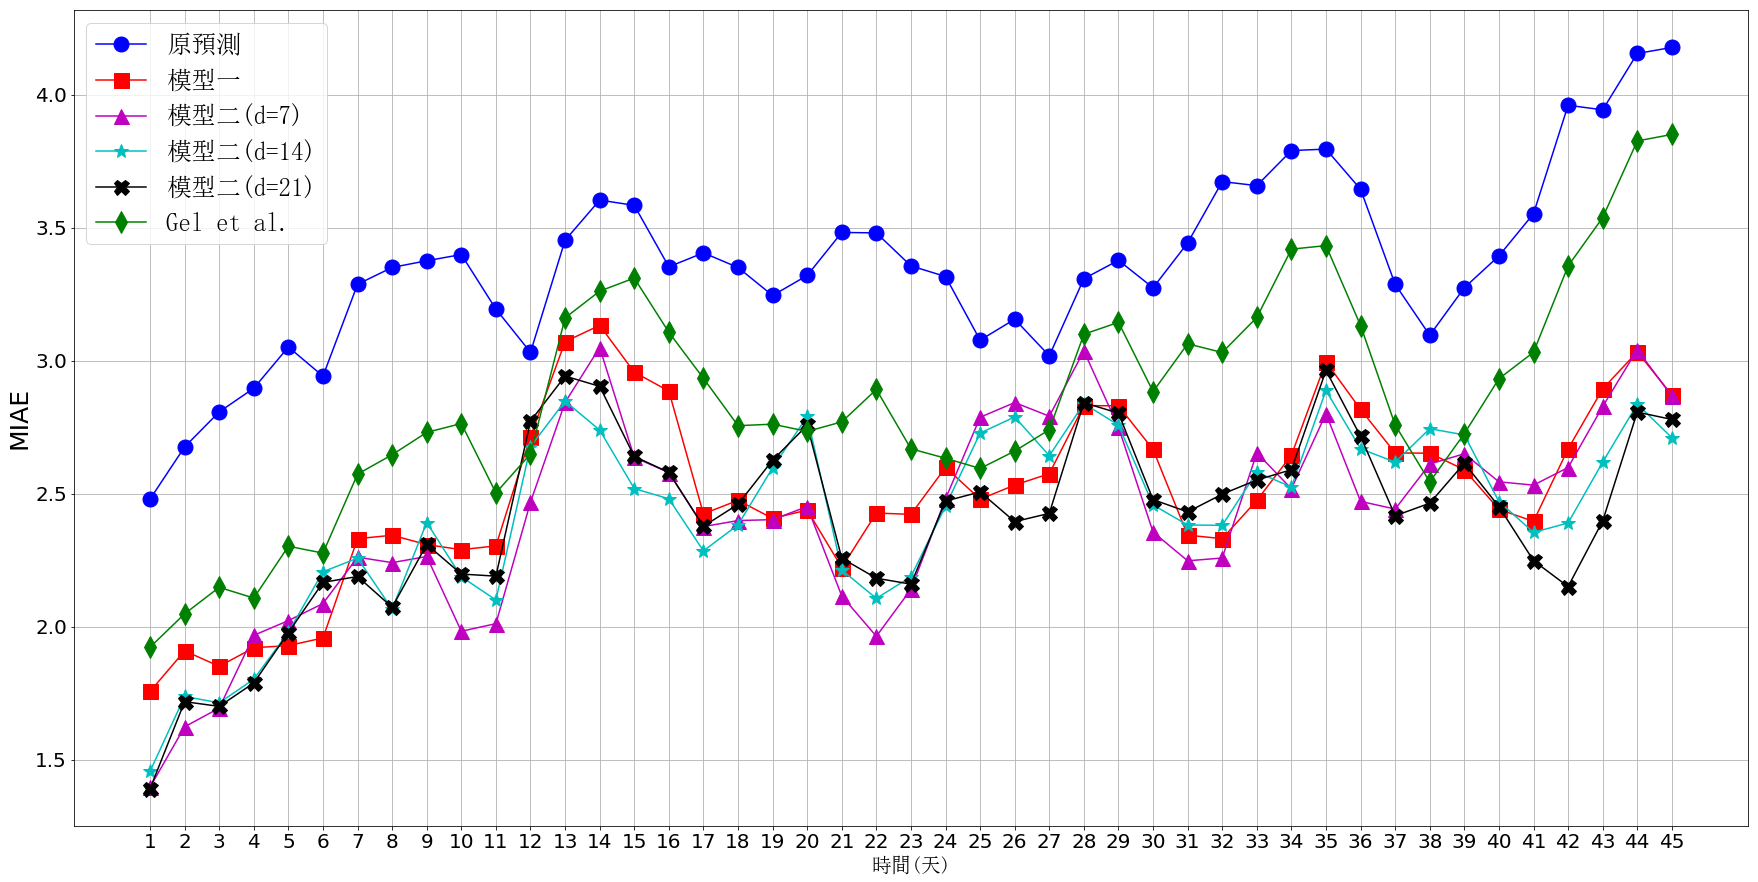

In [31]:
#compare test MIAE

fig = plt.figure(figsize = (30, 15))
plt.plot(np.arange(1, n_day+1), mean_daily_AE_forecast, 'b', marker = 'o', markersize = 15, label = '原預測')
plt.plot(np.arange(1, n_day+1), mean_daily_AE, 'r', marker = 's', markersize = 15, label = '模型一')
plt.plot(np.arange(1, n_day+1), mean_daily_AE_7days, 'm', marker = '^', markersize = 15, label = '模型二(d=7)')
plt.plot(np.arange(1, n_day+1), mean_daily_AE_14days, 'c', marker = '*', markersize = 15, label = '模型二(d=14)')
plt.plot(np.arange(1, n_day+1), mean_daily_AE_21days, 'k', marker = 'X', markersize = 15, label = '模型二(d=21)')
#plt.plot(np.arange(1, n_day+1), mean_daily_AE_45days, 'y', label = '模型二(d=45)')
plt.plot(np.arange(1, n_day+1), mean_daily_AE_lm, 'g', marker = 'd', markersize = 15, label = 'Gel et al.')
plt.xticks(np.arange(n_day)+1, fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('時間(天)', fontproperties = font)
plt.ylabel('MIAE', fontsize = 25)
font = FontProperties(fname=r"c:\windows\Fonts\SimSun.ttc", size=25)
plt.legend(prop = font)
#plt.title('MIAE')
plt.grid(True)
fig.savefig('MIAE.png')
plt.show()

In [33]:
def Plot_temp(temp, fun, time, title, save_name, vmin = 0, vmax = 30):
    lat = np.arange(22, 25.3, 0.1)
    lon = np.arange(120, 122, 0.1)
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    temp_grid =  sp.interpolate.griddata(grid_obs, temp[fun][time], (lat_grid, lon_grid), method = 'linear') - 273.15
    fig = plt.figure(figsize = (6, 8))
    map1 = Basemap(llcrnrlon = 120, llcrnrlat = 21.9, urcrnrlon = 122, urcrnrlat = 25.3, 
                   resolution = 'i', lat_0 = 23.5, lon_0 = 120.5)
    x, y = map1(lon_grid, lat_grid)
    m = np.ma.masked_where(np.isnan(temp_grid), temp_grid)
    map1.pcolormesh(x, y, m, vmin = vmin, vmax = vmax, cmap = 'jet')
    map1.drawcoastlines()
    font = FontProperties(fname=r"c:\windows\Fonts\SimSun.ttc", size=20)
    plt.xticks(np.arange(120, 122.1, 0.5))
    plt.yticks(np.arange(22, 25.3, 1))
    plt.xlabel('經度', fontproperties = font)
    plt.ylabel('緯度', fontproperties = font)
    #plt.legend(bbox_to_anchor=(1, 1), loc = 2)
    #plt.grid(True)
    plt.colorbar()
    #plt.title(title, fontproperties = font)
    fig.savefig(save_name+'.png')
    plt.show()

In [32]:
test_time_index[12], test_time_index[18]

(array([ 20160112.,  20160226.]), array([ 20160712.,  20160826.]))

In [ ]:
Plot_temp(test_temp_obs, 12, 0, title = str('觀測溫度'), save_name = str('20160112obs'))
Plot_temp(test_temp_forecast_interp.reshape(n_test, n_day*n_hour, -1), 12, 0, title = str('預測溫度(原預測)'), save_name = str('20160112forecast'))
Plot_temp(temp_pred.reshape(n_test, n_day*n_hour, -1), 12, 0, title = str('預測溫度(模型一)'), save_name = str('20160112model1'))
Plot_temp(temp_pred2.reshape(n_test, n_day*n_hour, -1), 12, 0, title = str('預測溫度(模型二d=7)'), save_name = str('20160112model2(d=7)'))
Plot_temp(temp_pred3.reshape(n_test, n_day*n_hour, -1), 12, 0, title = str('預測溫度(模型二d=14)'), save_name = str('20160112model2(d=14)'))
Plot_temp(temp_pred4.reshape(n_test, n_day*n_hour, -1), 12, 0, title = str('預測溫度(模型二d=21)'), save_name = str('20160112model2(d=21)'))
Plot_temp(temp_pred_lm.reshape(n_test, n_day*n_hour, -1), 12, 0, title = str('預測溫度(模型三)'), save_name = str('20160112model3'))

In [ ]:
Plot_temp(test_temp_obs, 18, 0, title = str('觀測溫度'), save_name = str('20160712obs'))
Plot_temp(test_temp_forecast_interp.reshape(n_test, n_day*n_hour, -1), 18, 0, title = str('預測溫度(原預測)'), save_name = str('20160712forecast'))
Plot_temp(temp_pred.reshape(n_test, n_day*n_hour, -1), 18, 0, title = str('預測溫度(模型一)'), save_name = str('20160712model1'))
Plot_temp(temp_pred2.reshape(n_test, n_day*n_hour, -1), 18, 0, title = str('預測溫度(模型二d=7)'), save_name = str('20160712model2(d=7)'))
Plot_temp(temp_pred3.reshape(n_test, n_day*n_hour, -1), 18, 0, title = str('預測溫度(模型二d=14)'), save_name = str('20160712model2(d=14)'))
Plot_temp(temp_pred4.reshape(n_test, n_day*n_hour, -1), 18, 0, title = str('預測溫度(模型二d=21)'), save_name = str('20160712model2(d=21)'))
Plot_temp(temp_pred_lm.reshape(n_test, n_day*n_hour, -1), 18, 0, title = str('預測溫度(模型三)'), save_name = str('20160712model3'))

In [43]:
test_time_index.shape

(23, 2)

In [38]:
str(int(test_time_index[0][0]))+'obs'

'20150112obs'

D:\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
D:\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


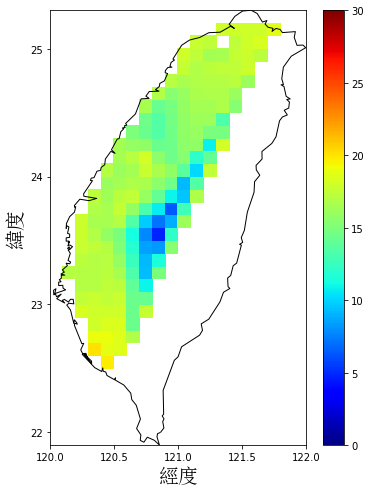

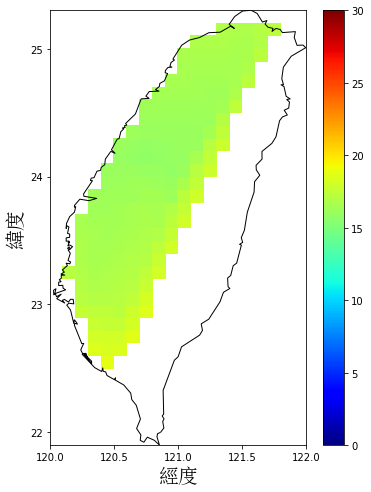

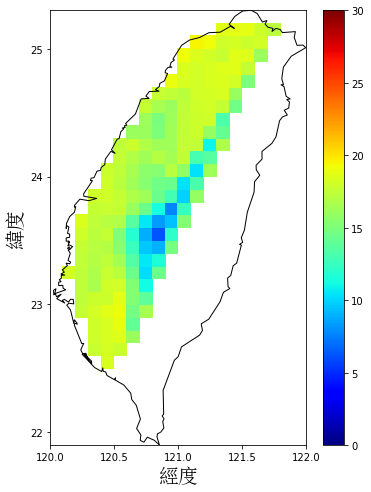

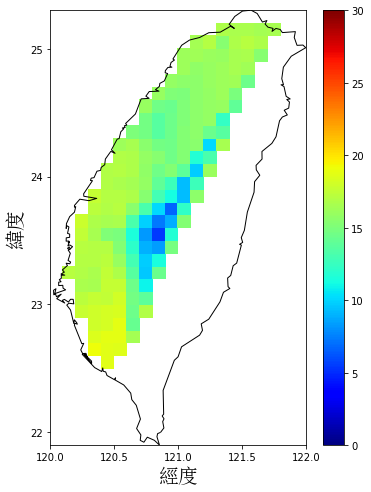

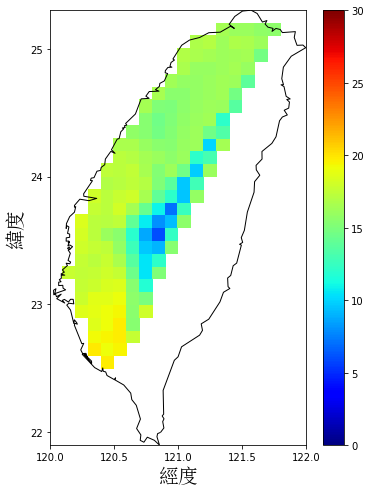

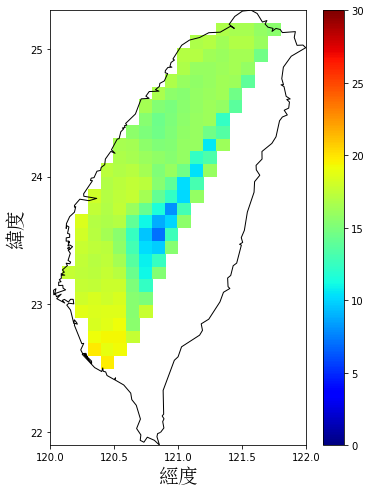

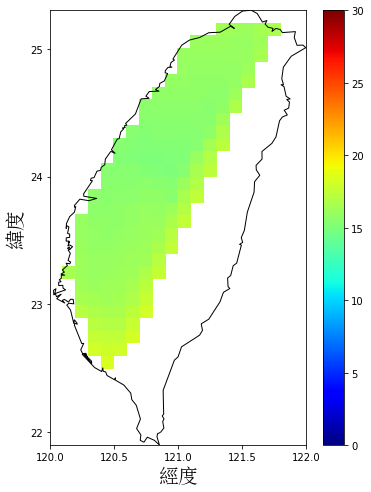

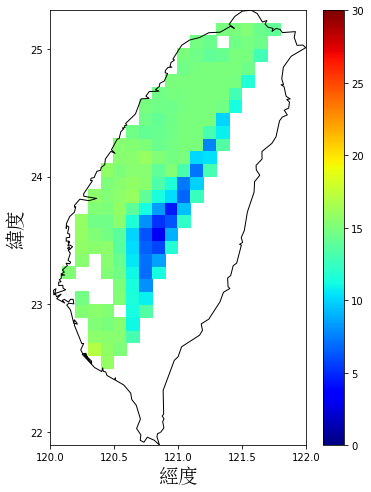

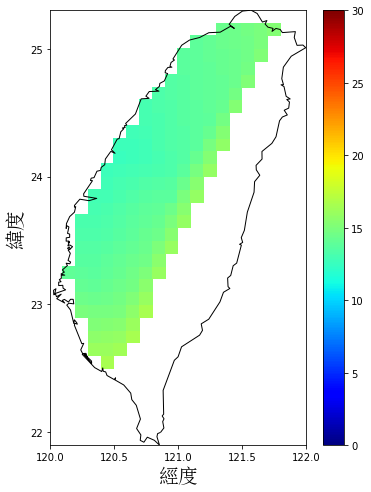

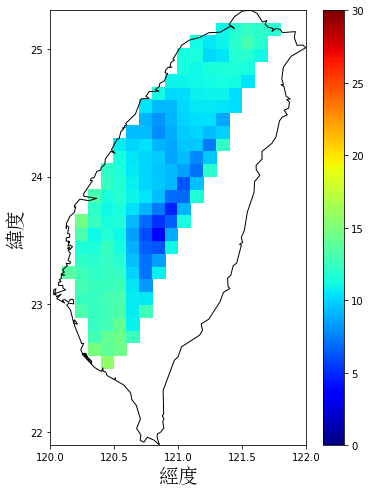

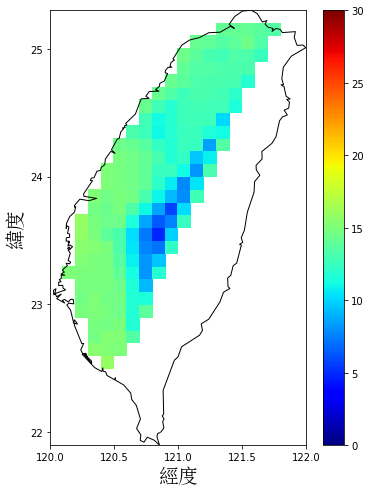

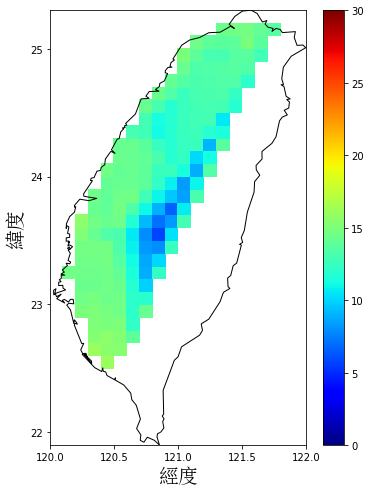

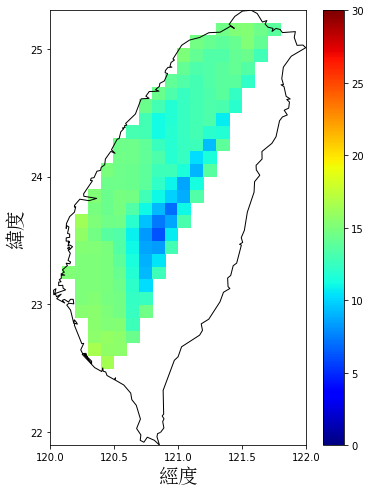

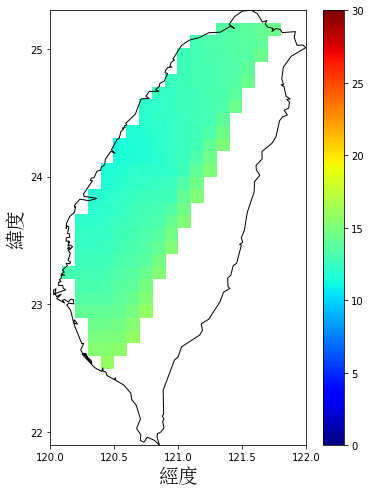

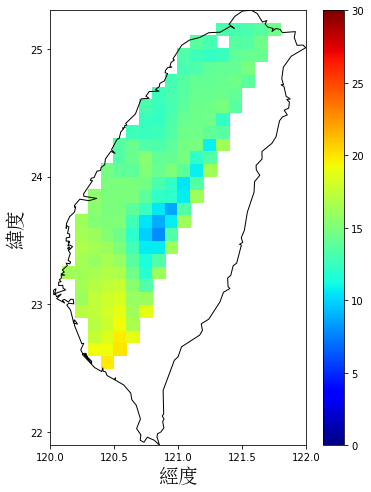

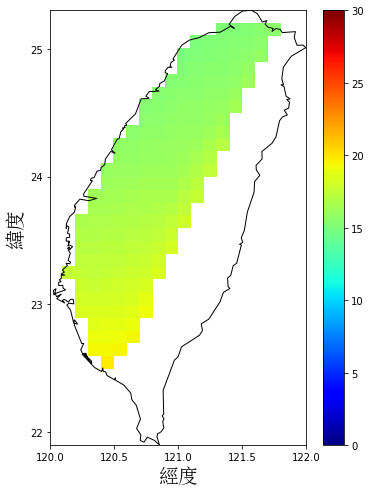

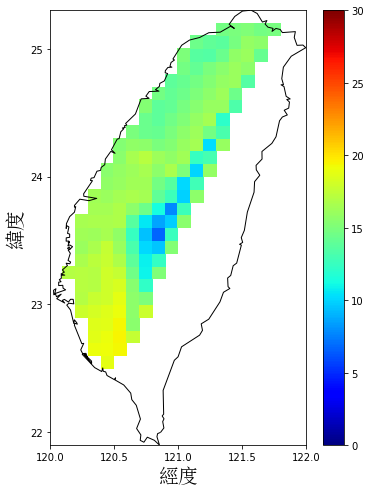

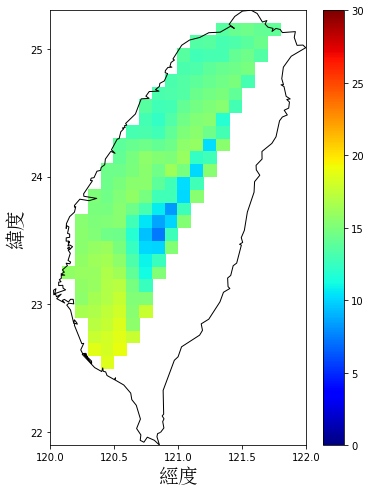

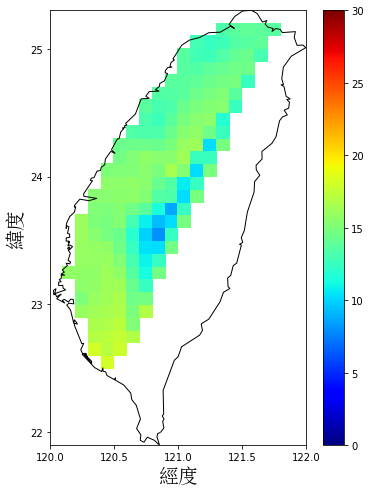

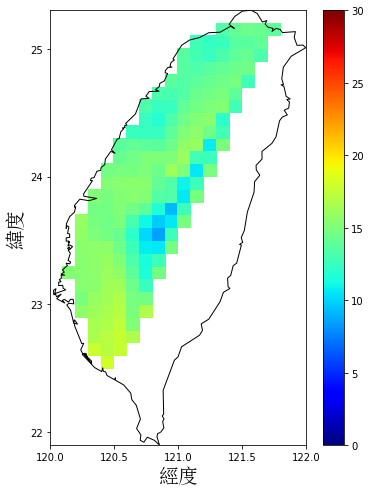

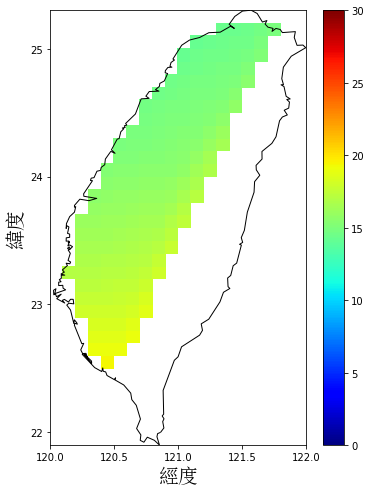

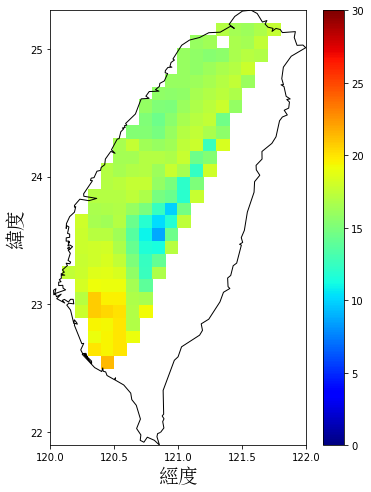

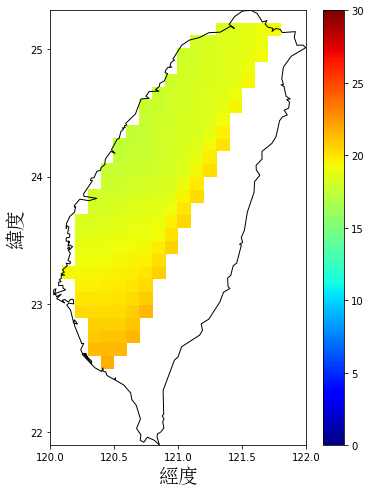

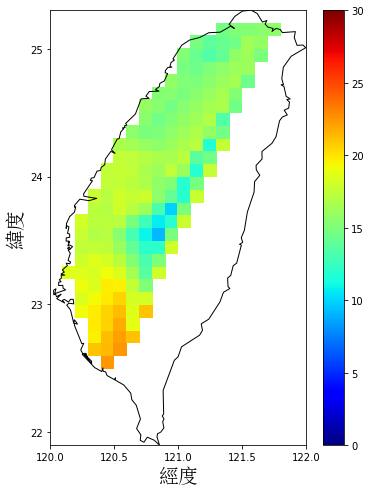

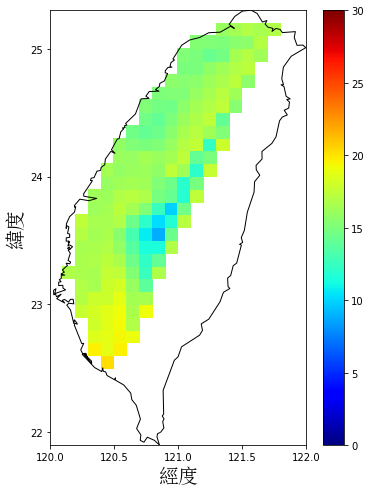

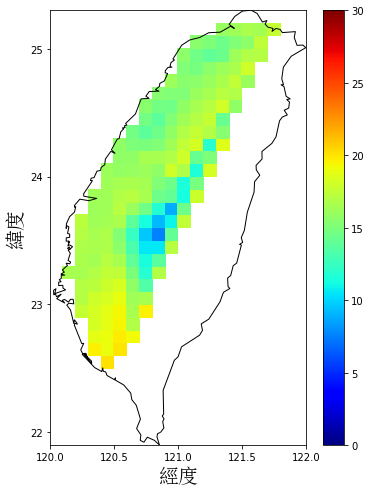

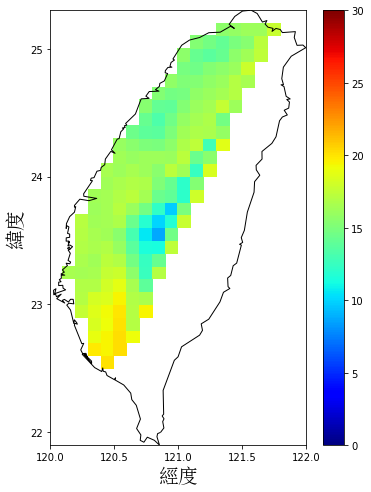

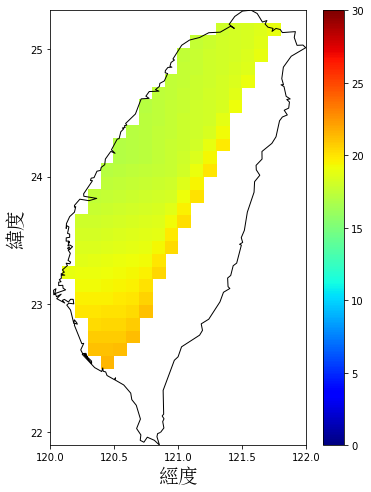

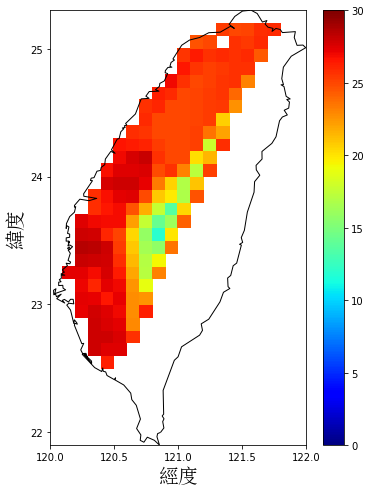

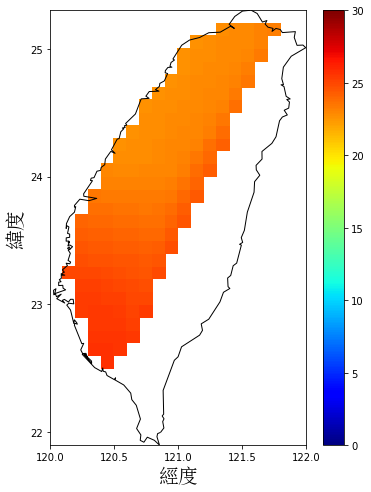

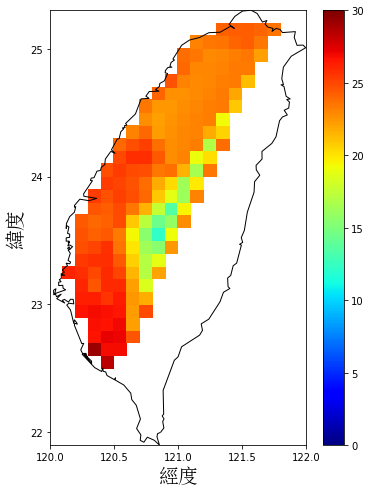

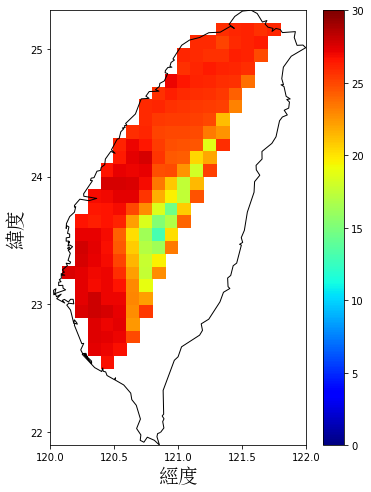

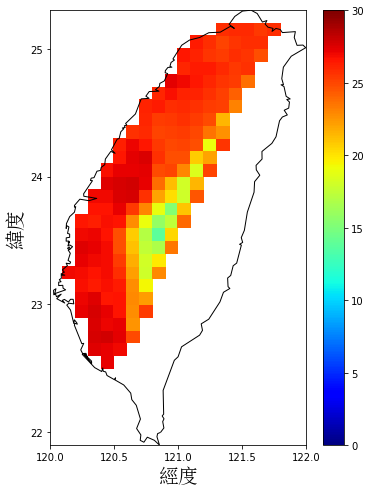

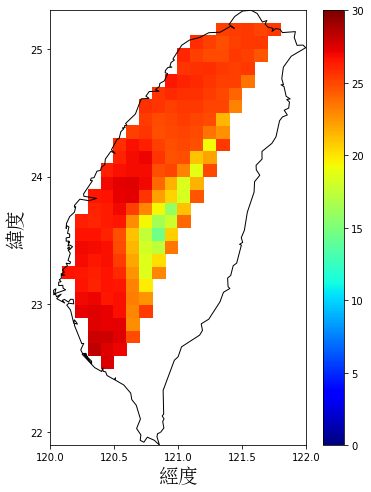

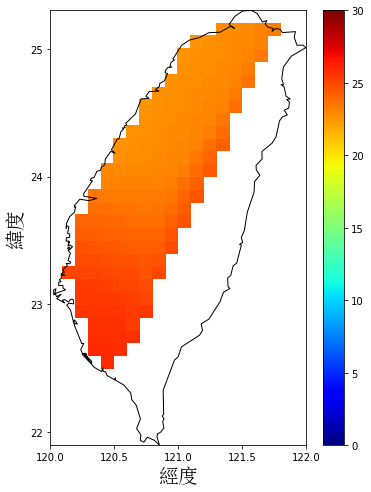

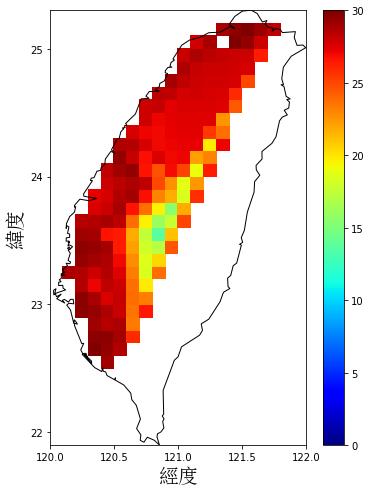

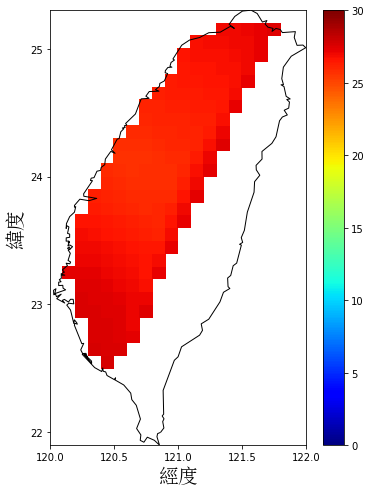

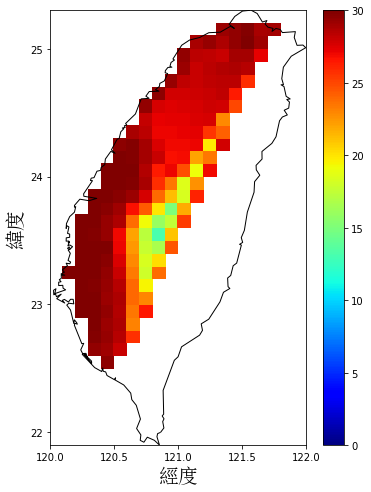

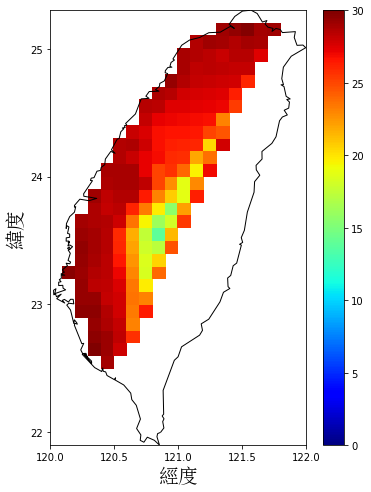

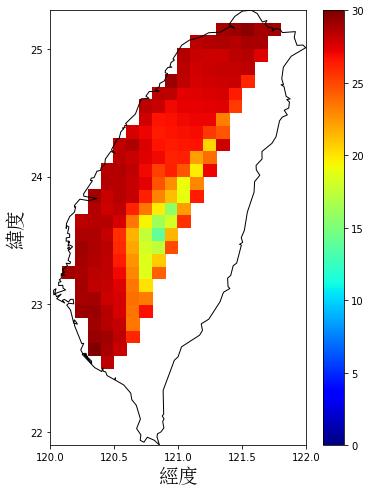

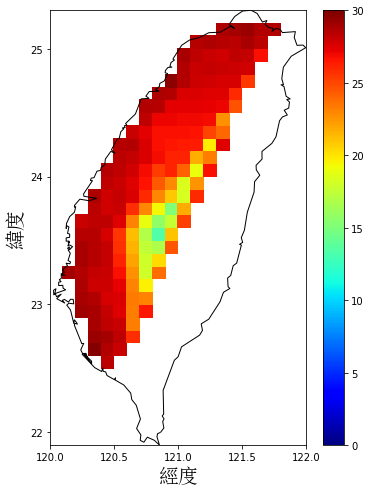

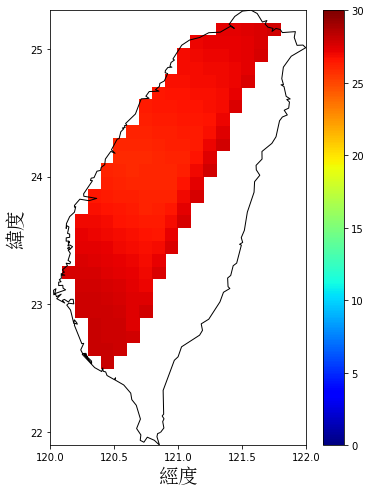

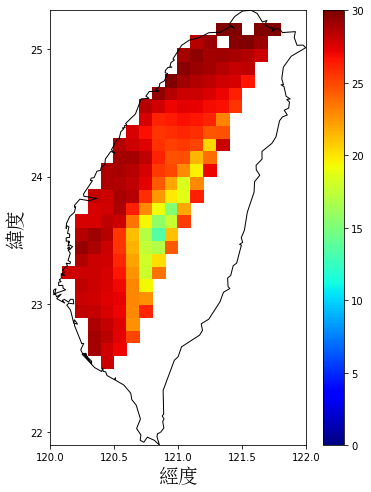

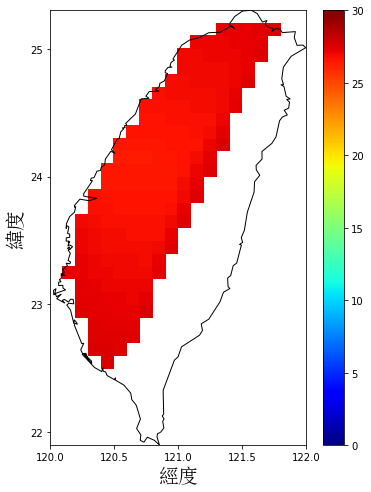

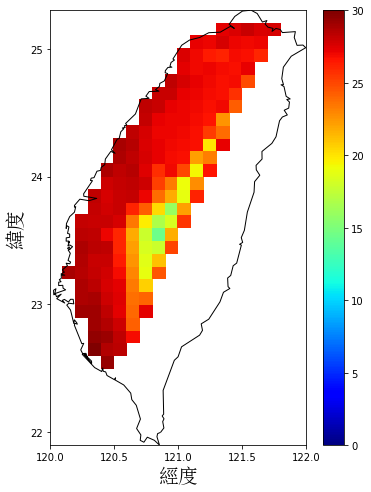

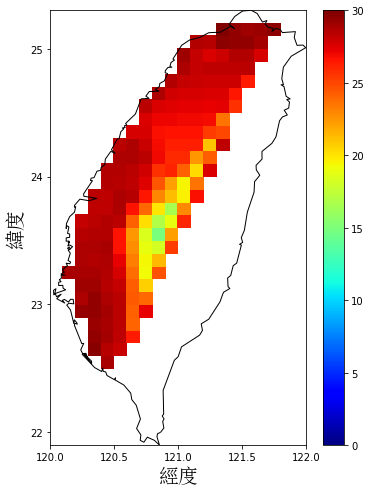

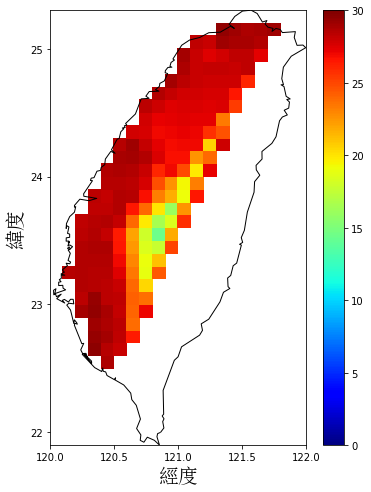

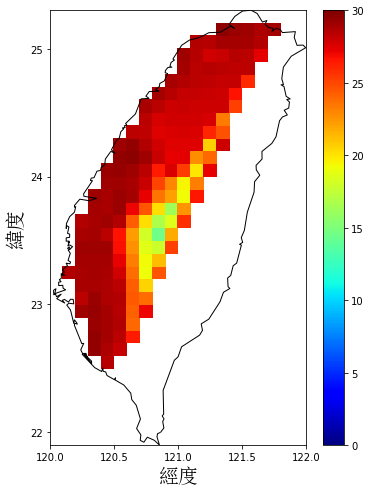

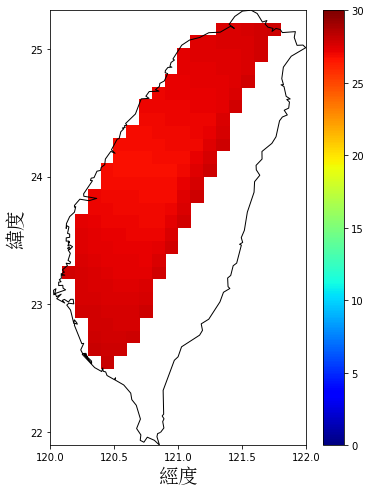

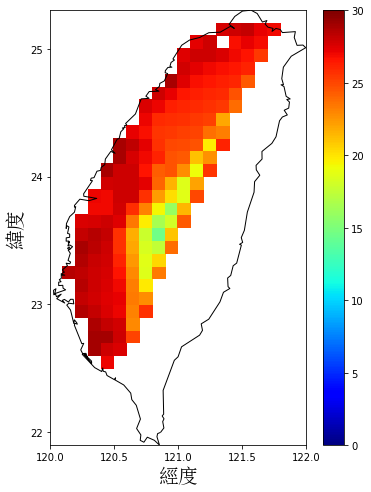

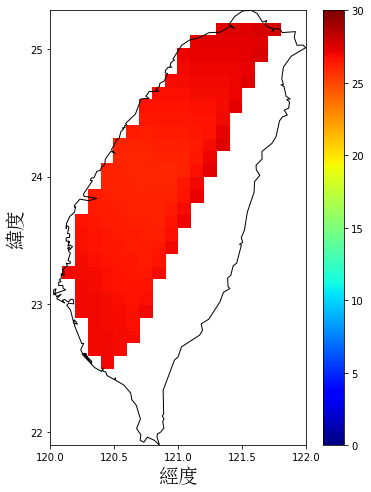

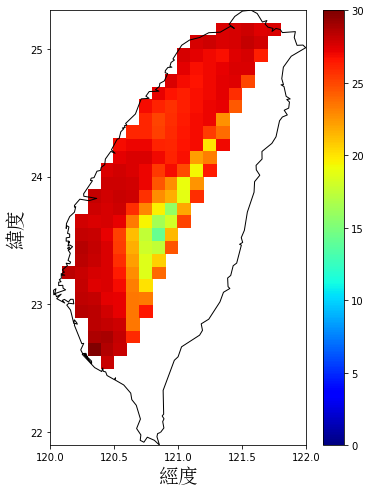

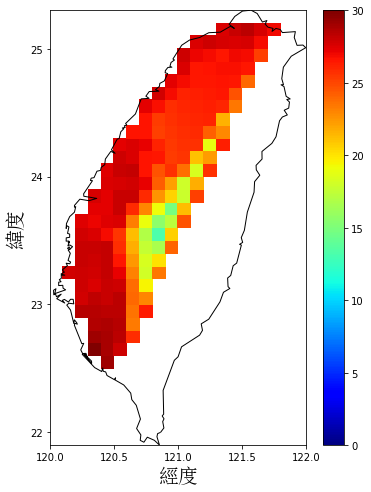

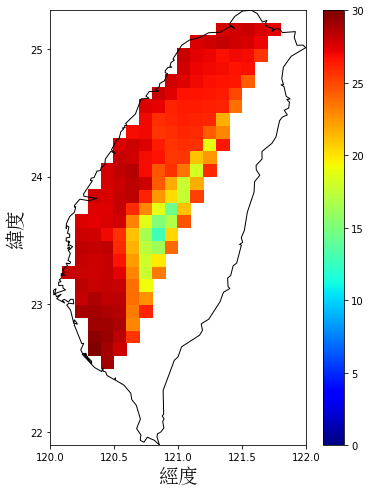

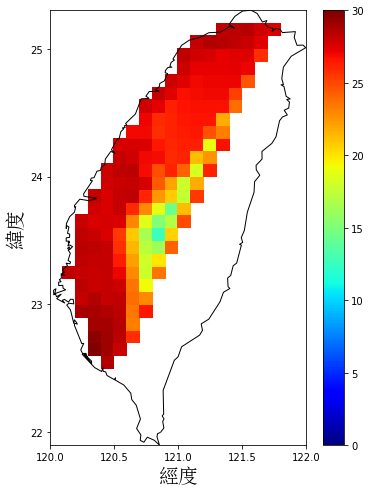

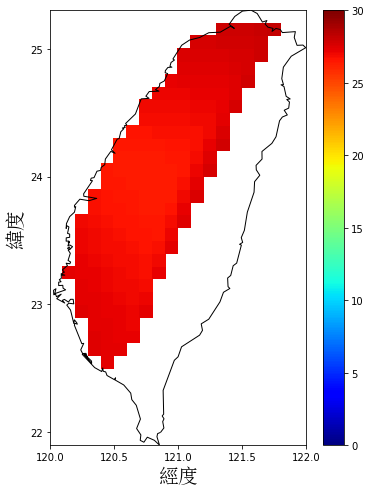

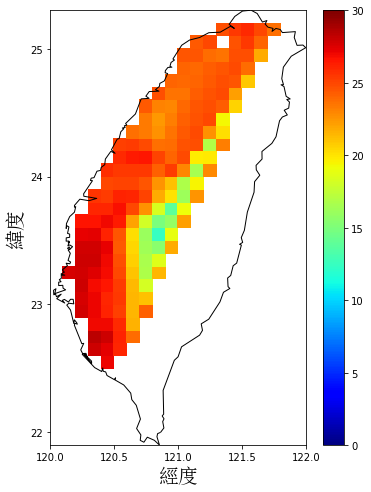

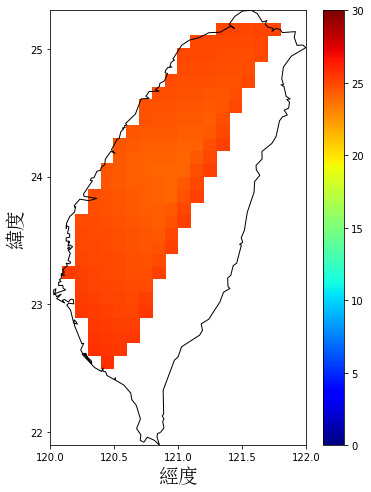

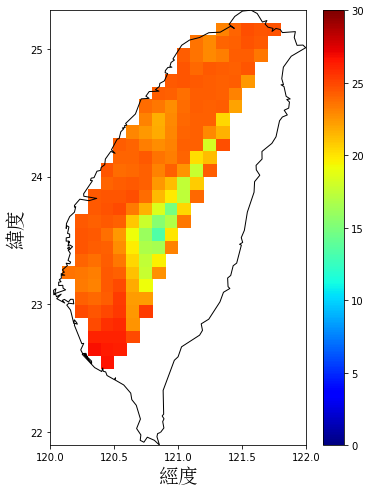

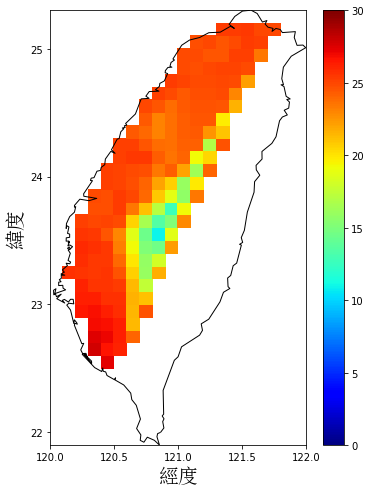

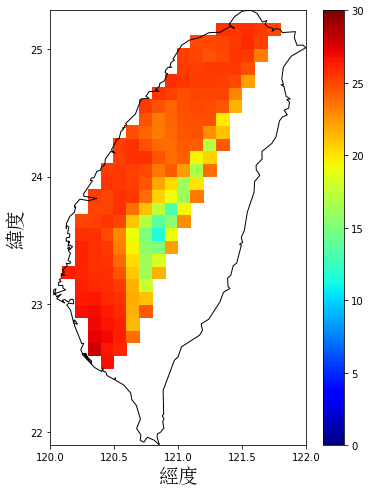

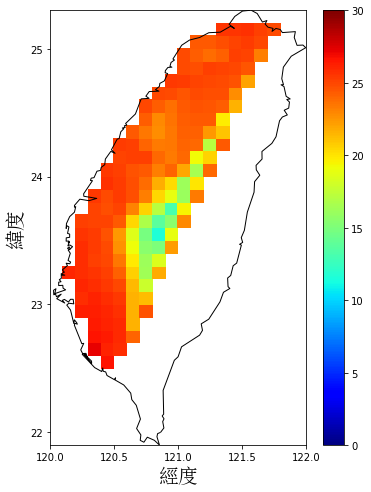

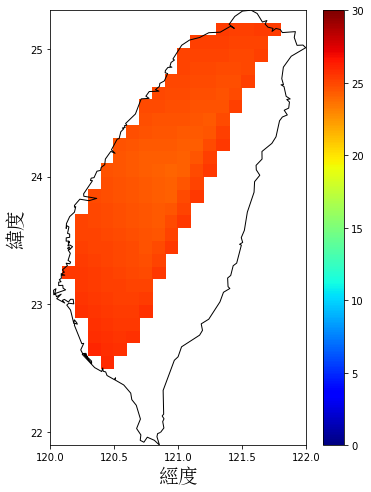

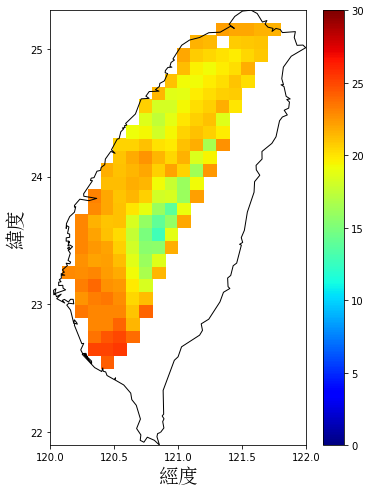

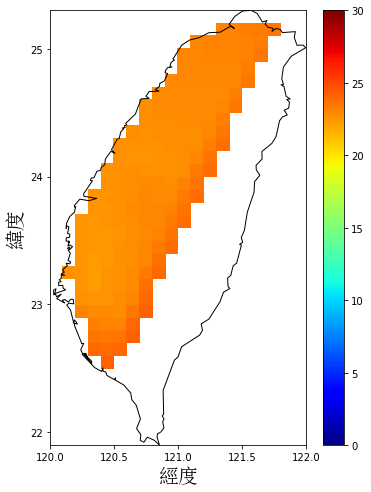

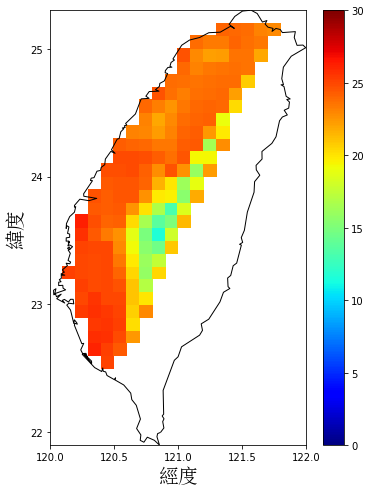

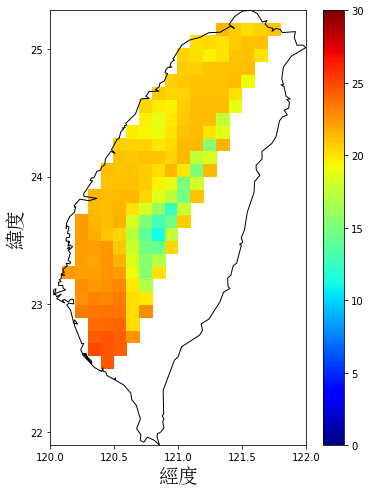

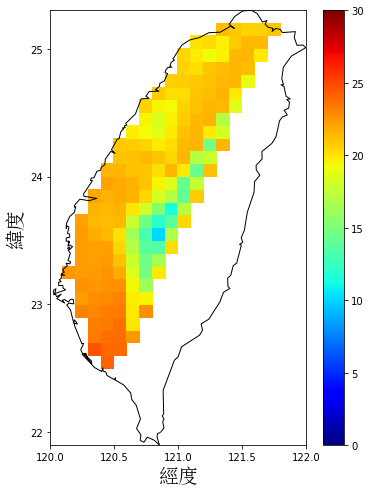

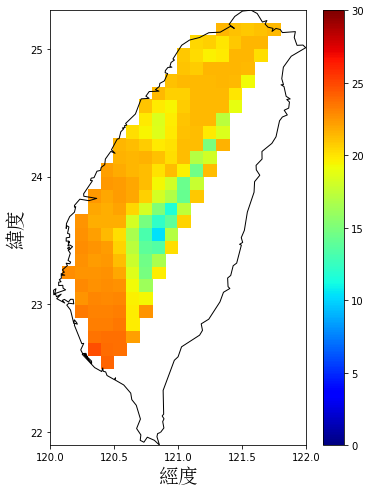

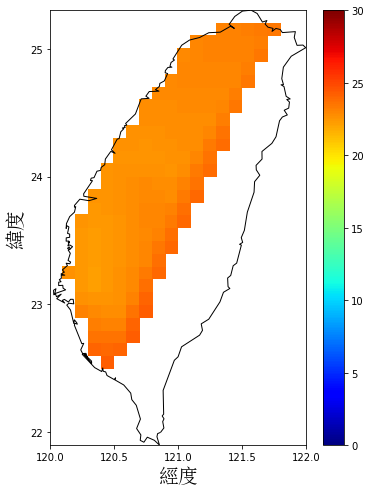

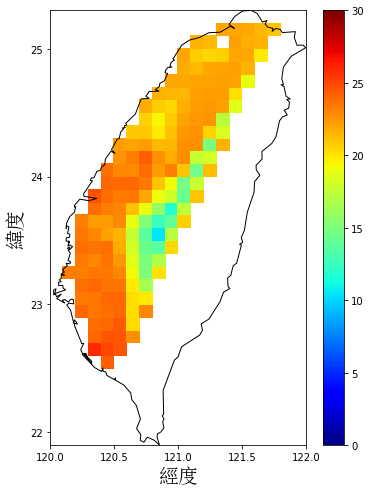

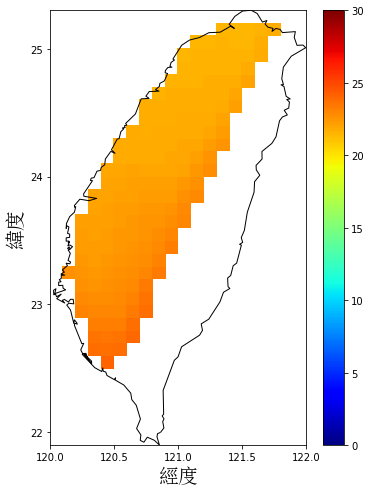

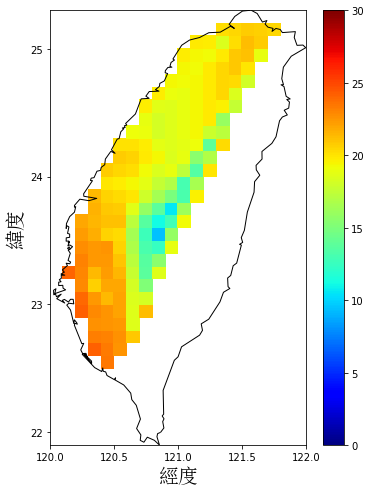

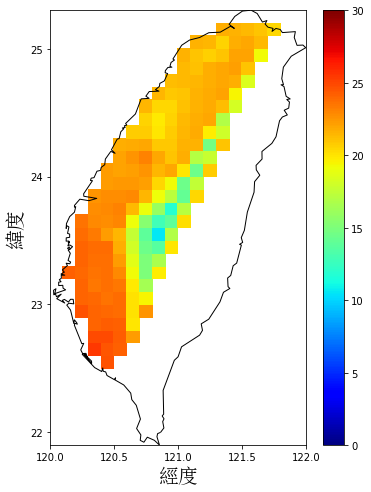

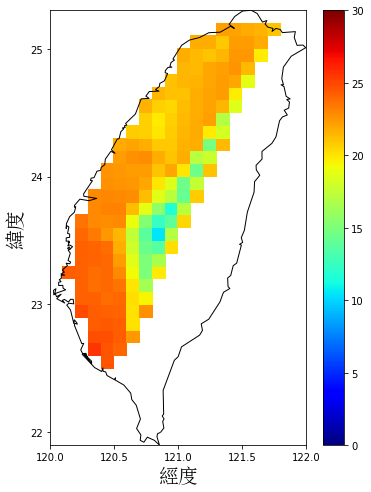

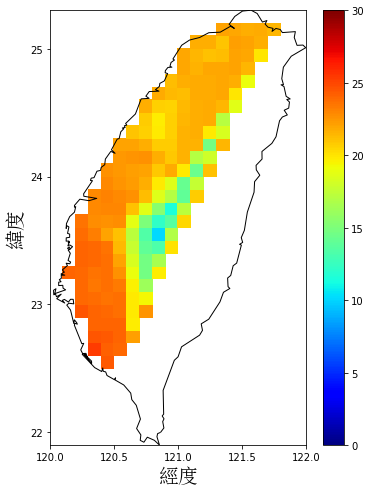

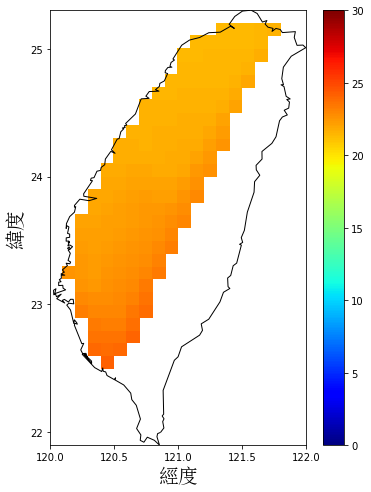

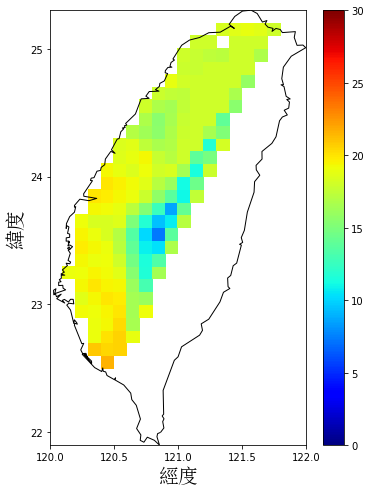

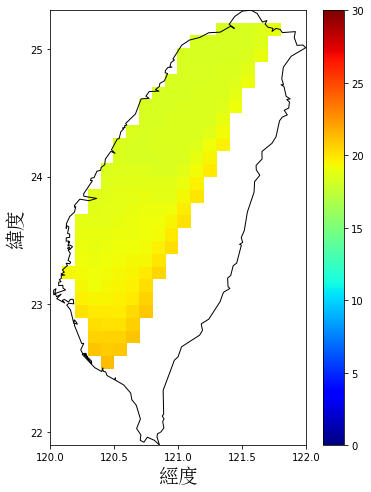

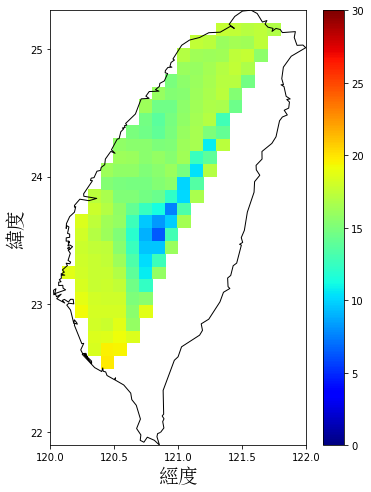

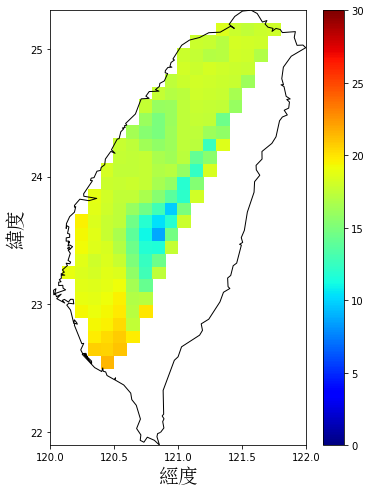

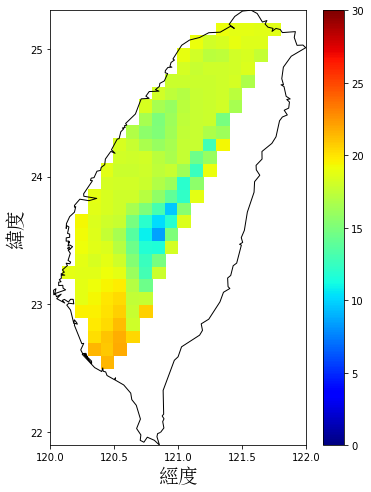

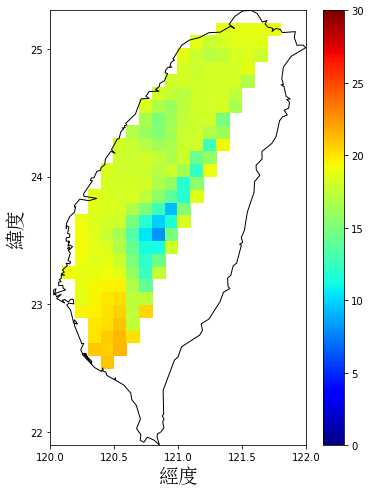

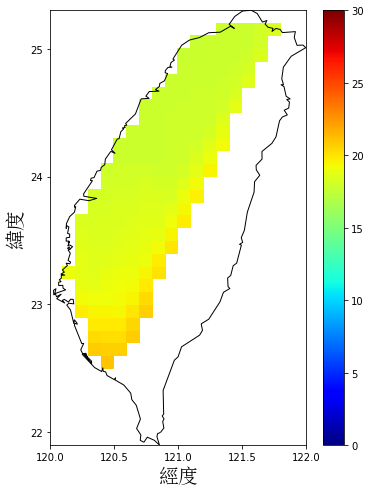

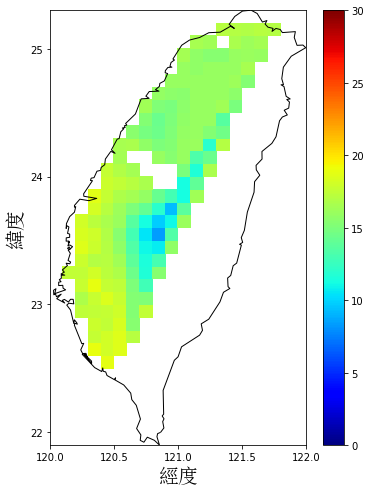

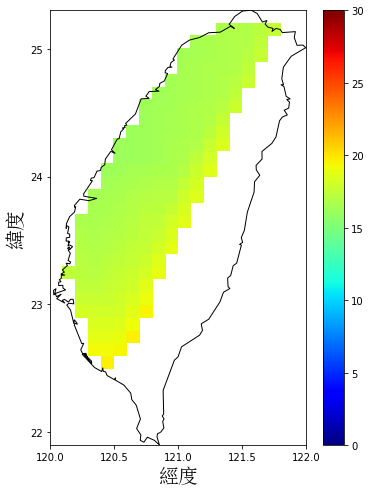

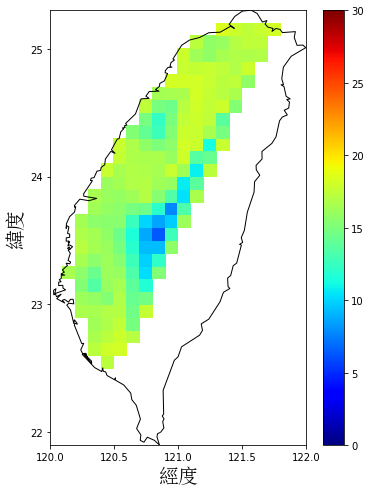

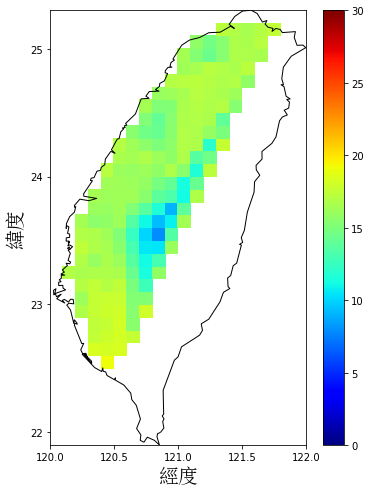

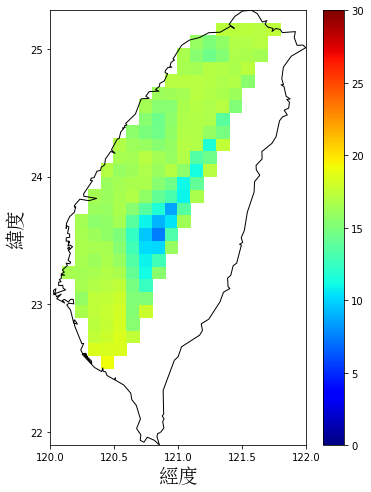

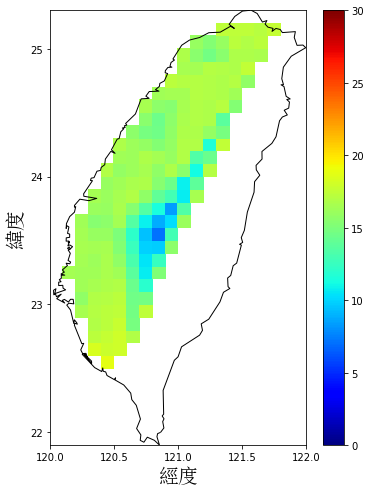

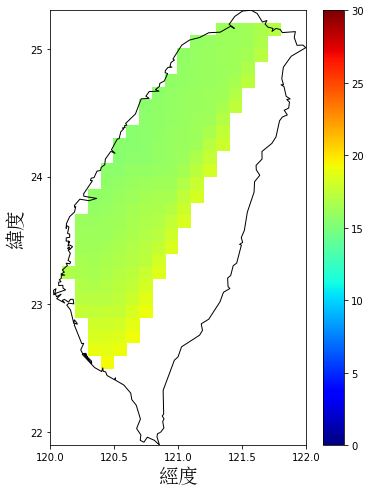

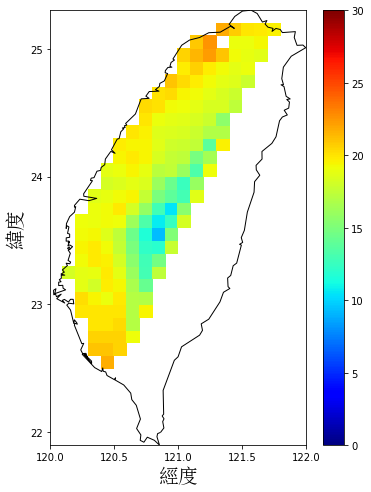

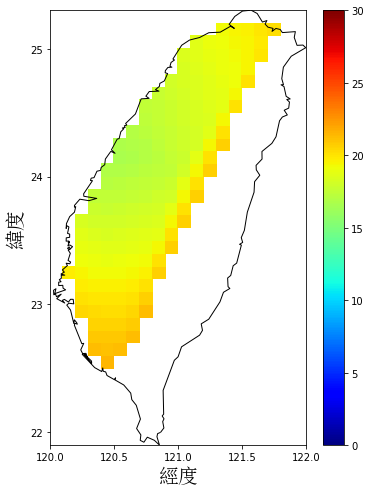

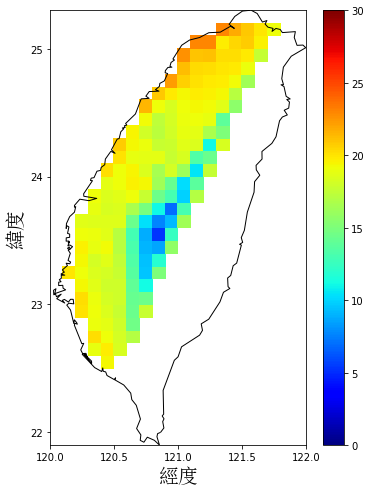

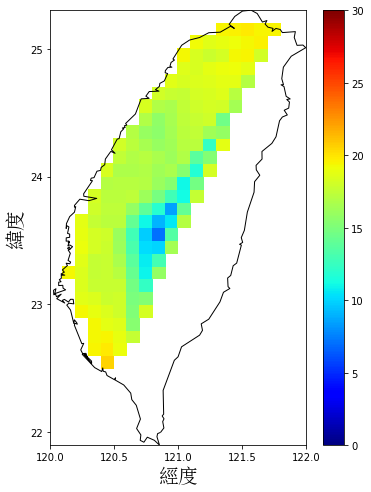

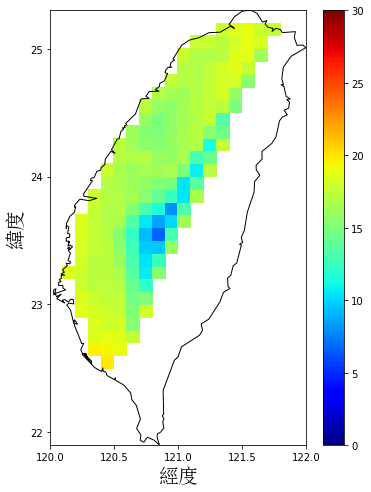

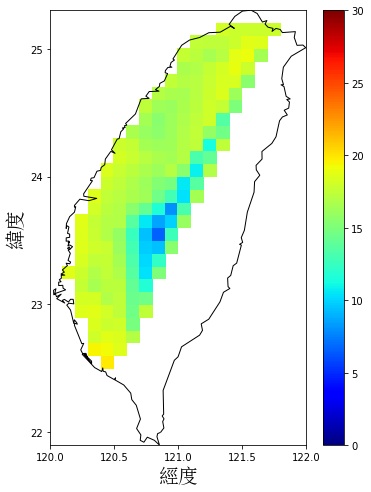

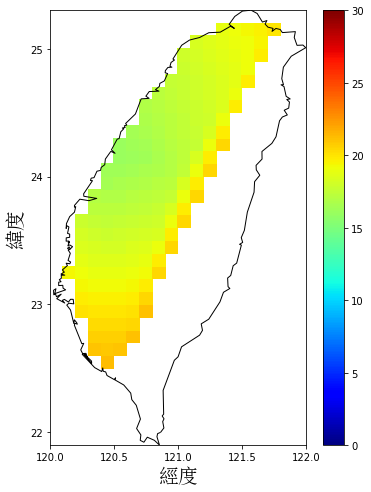

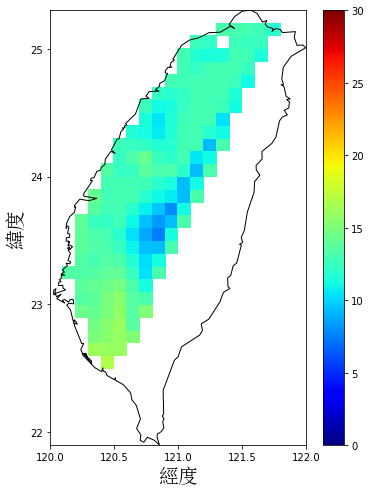

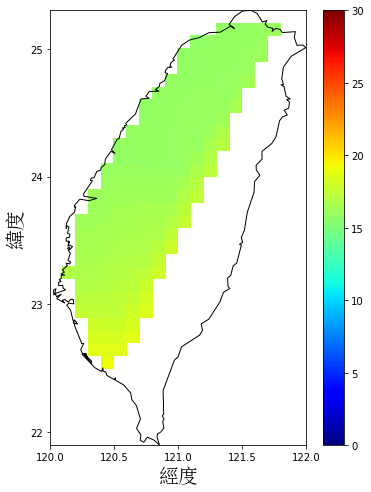

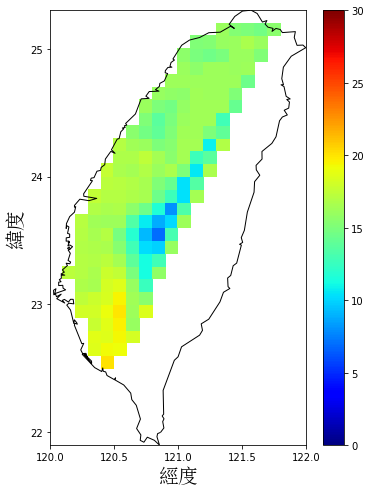

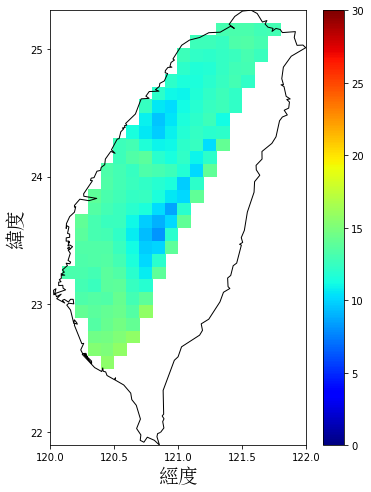

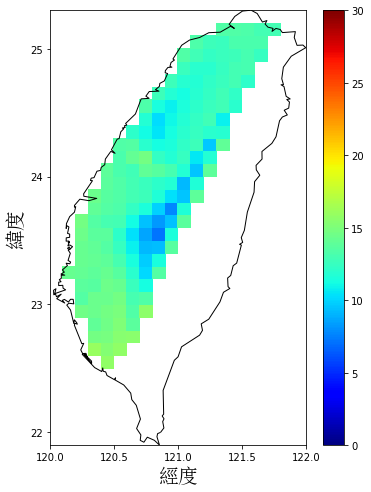

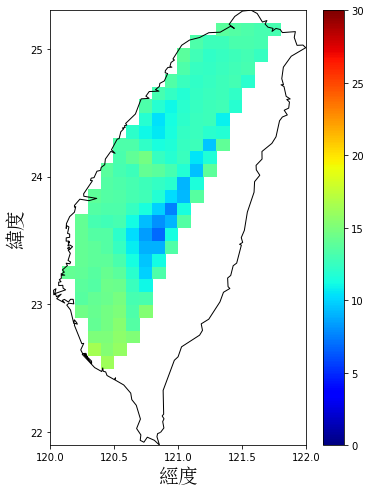

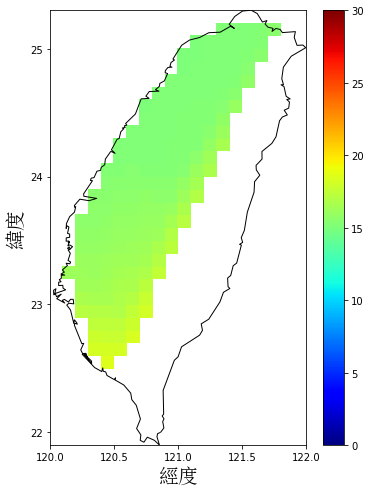

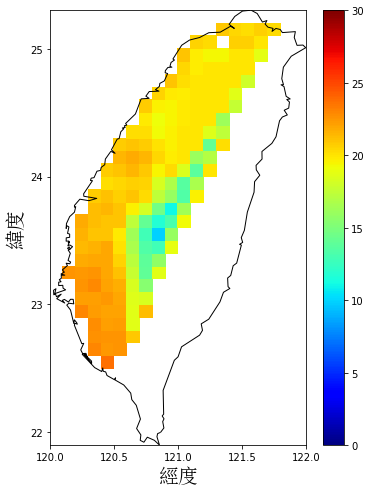

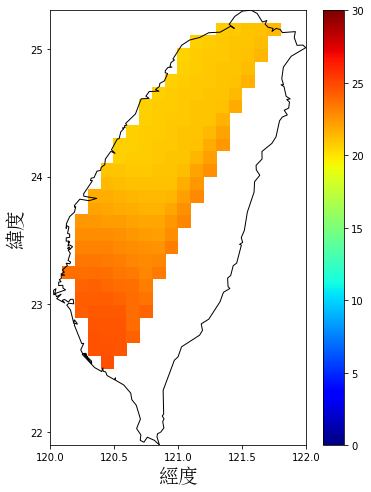

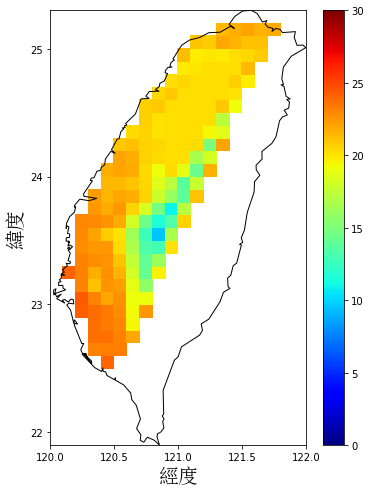

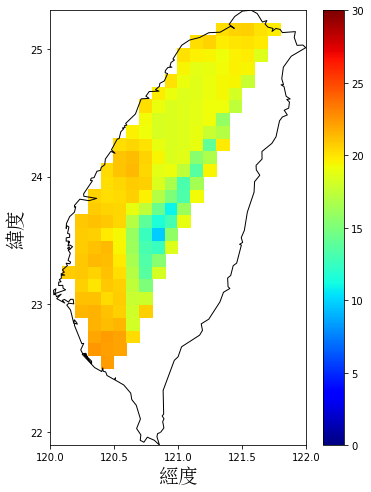

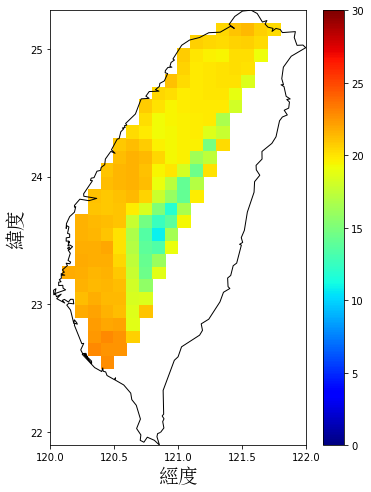

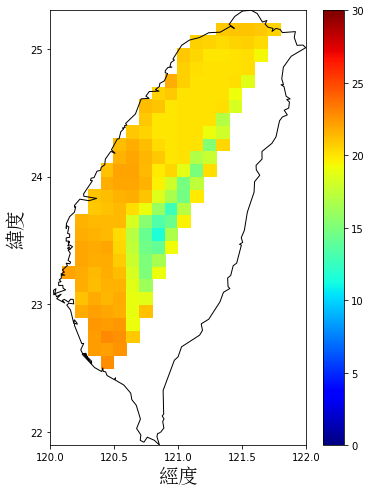

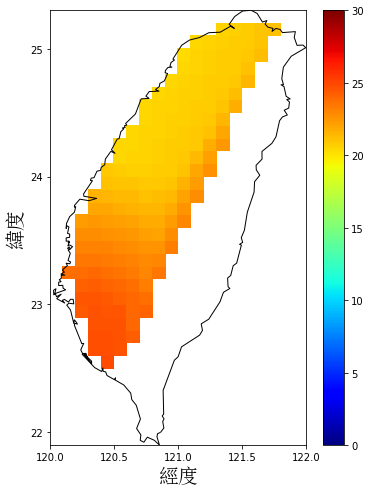

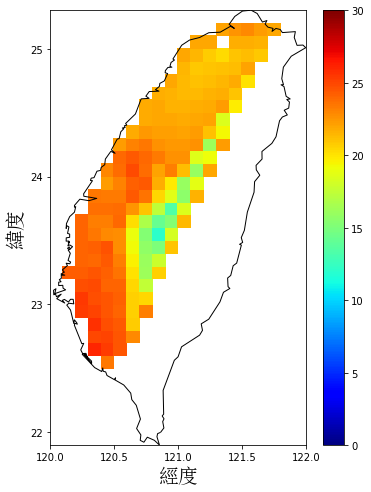

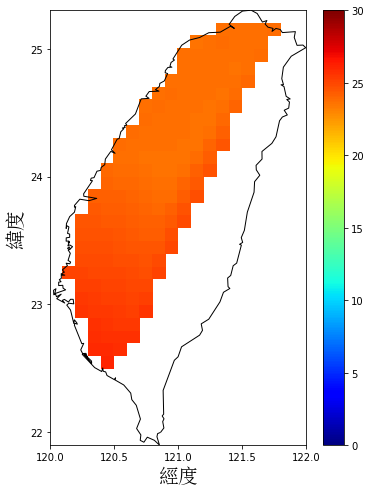

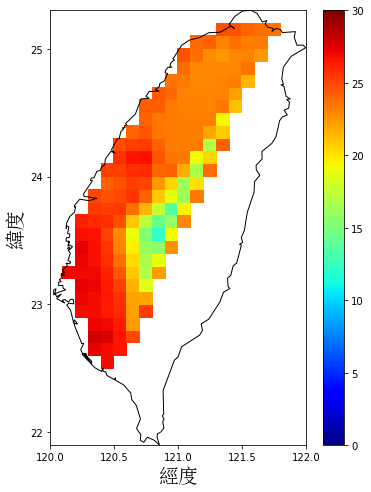

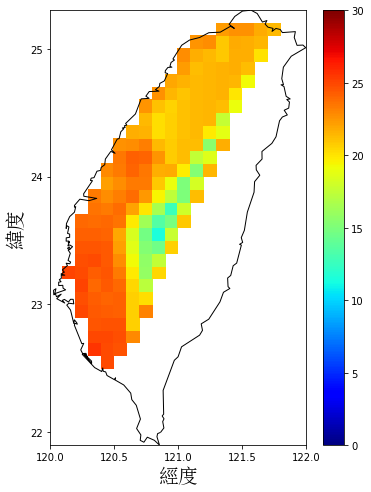

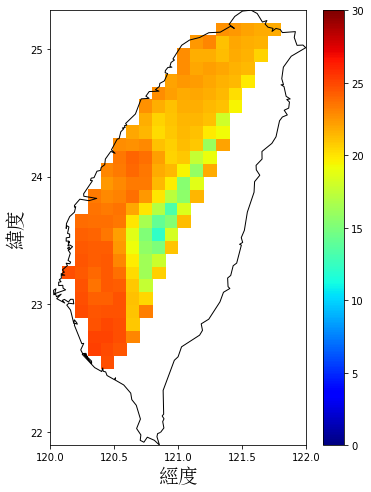

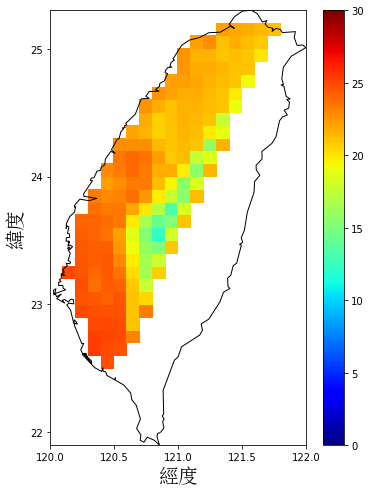

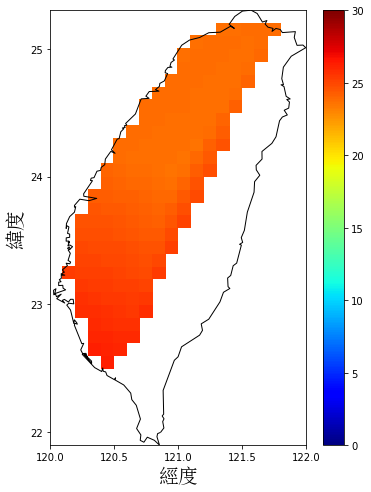

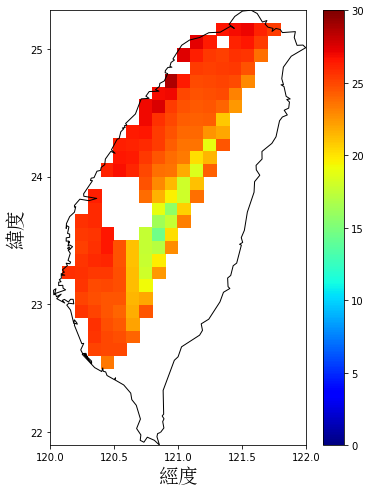

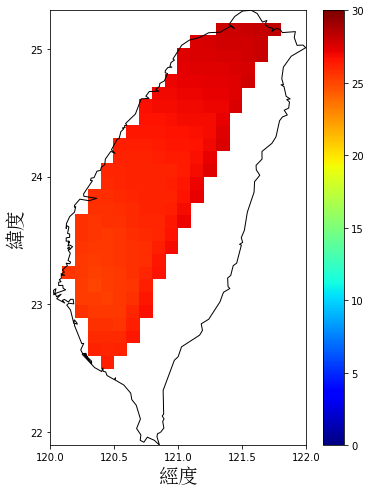

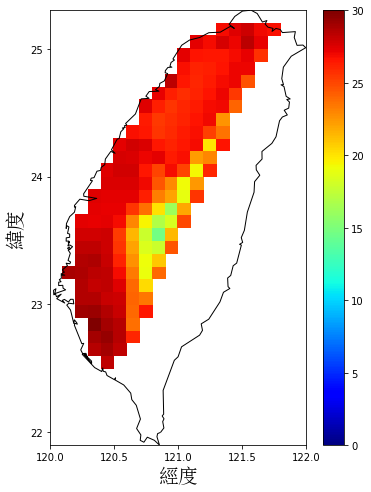

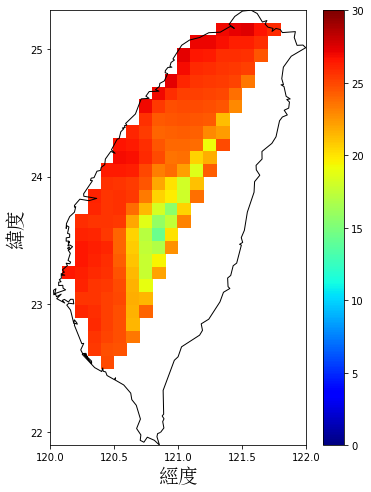

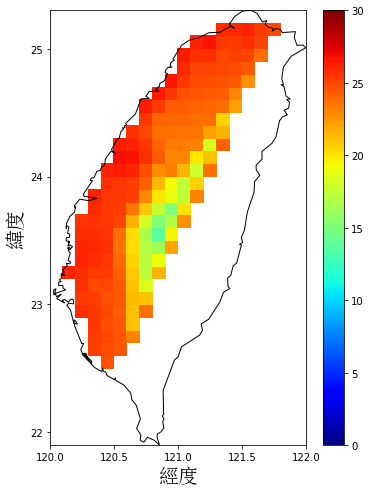

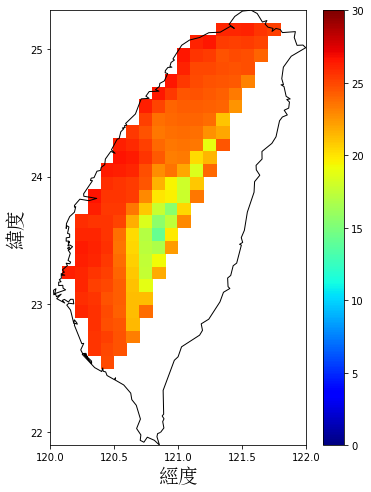

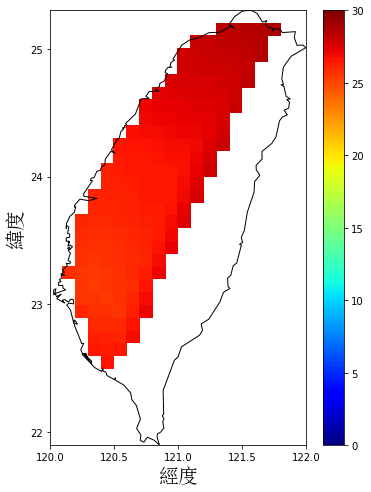

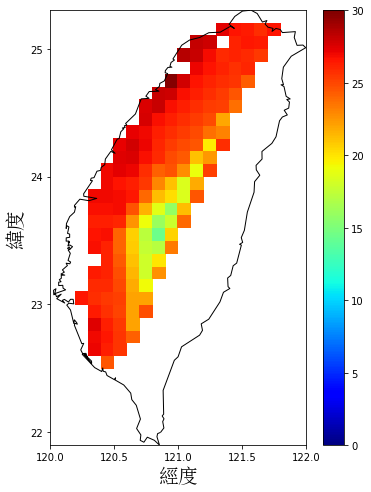

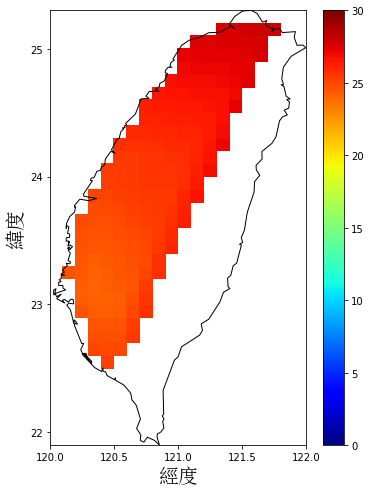

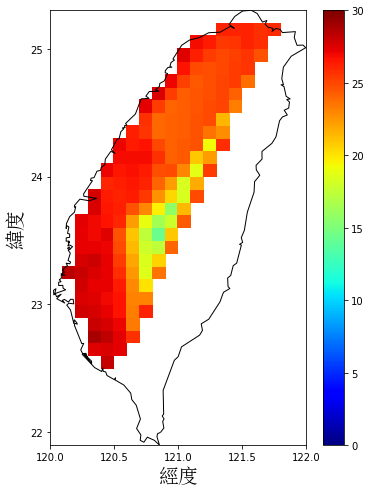

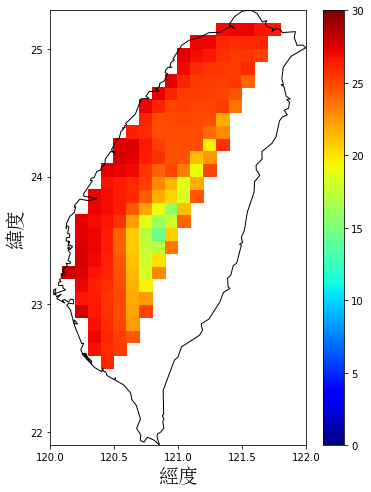

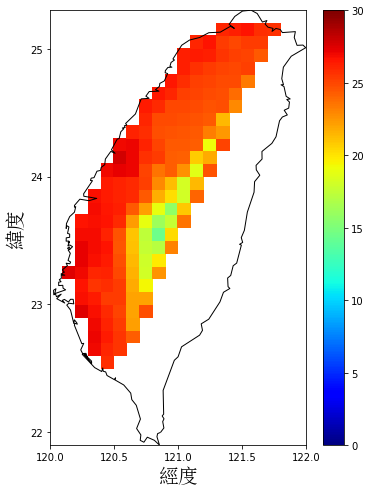

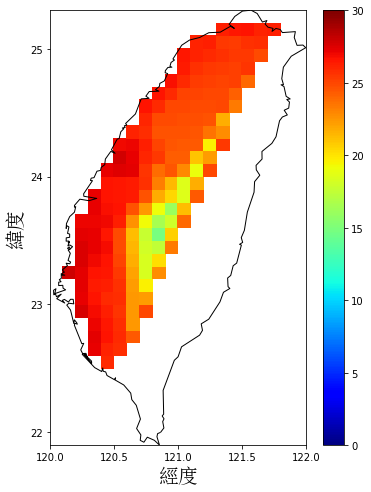

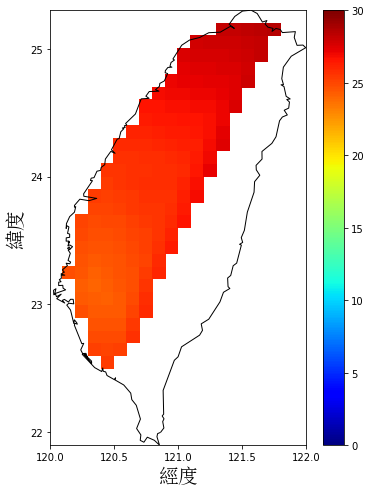

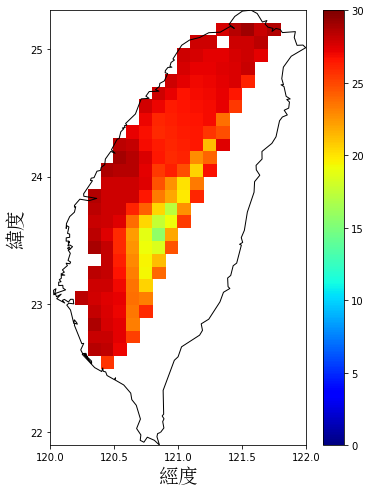

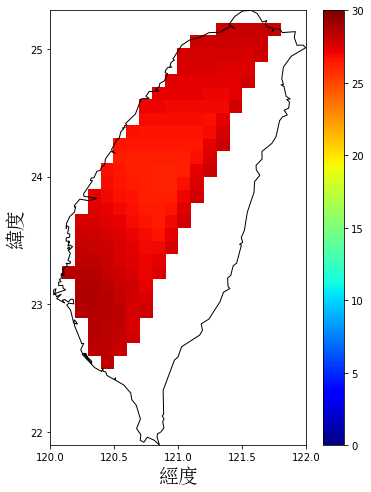

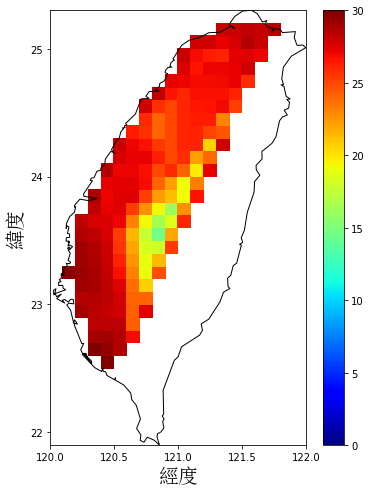

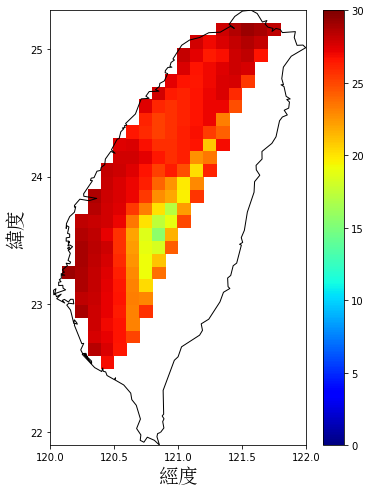

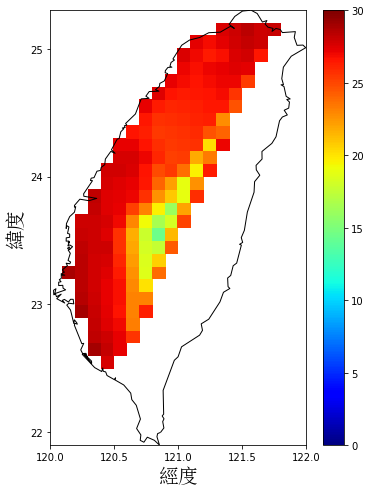

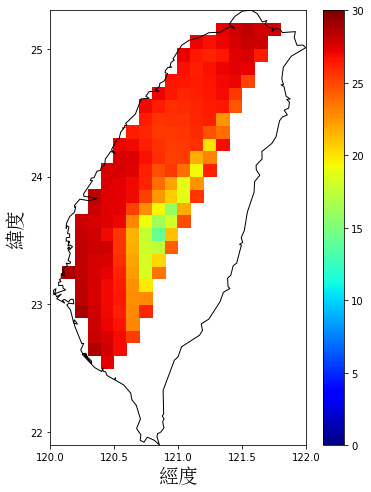

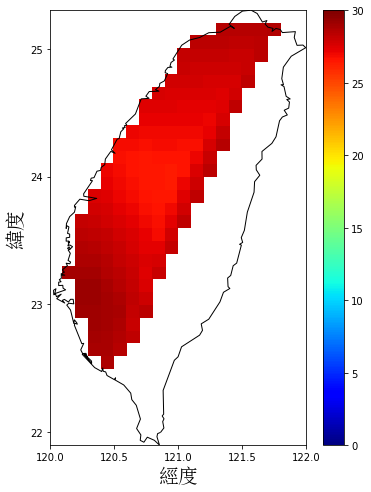

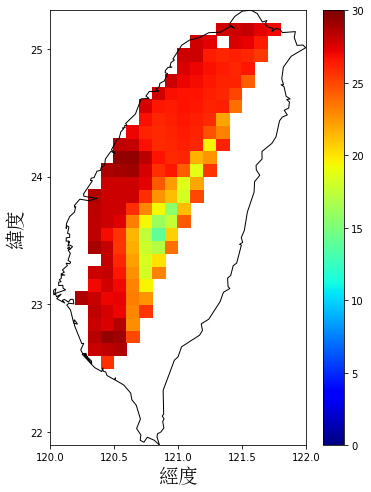

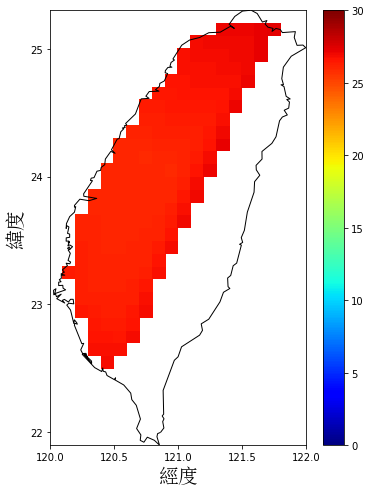

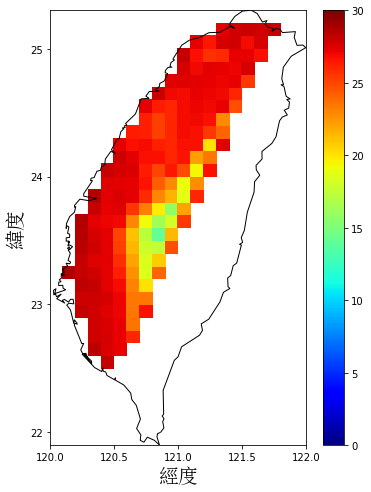

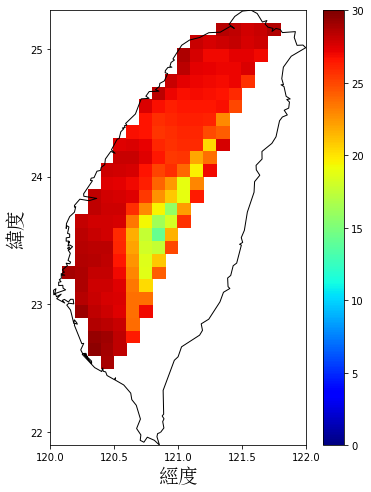

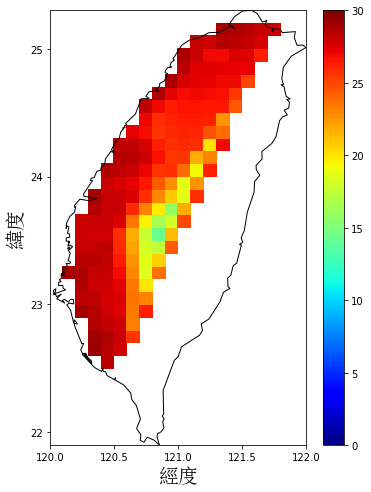

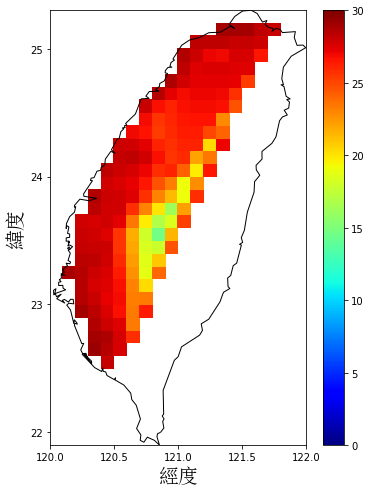

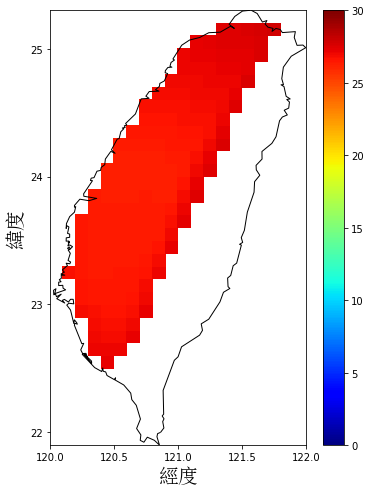

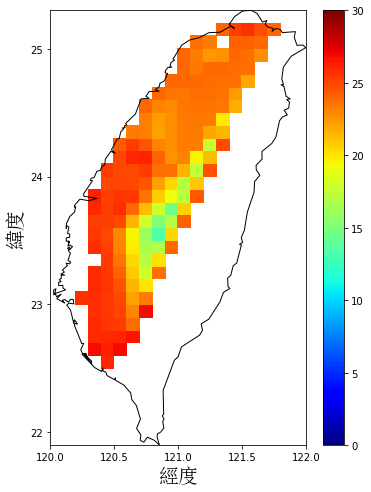

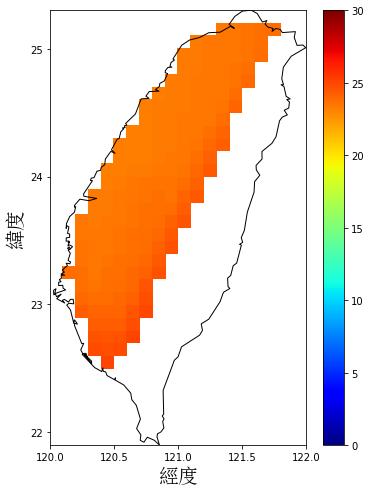

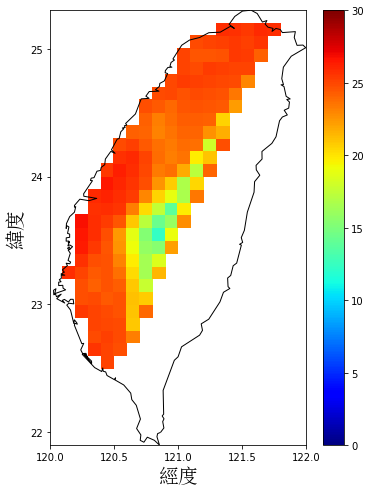

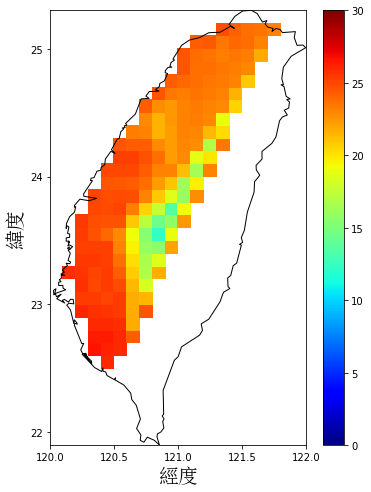

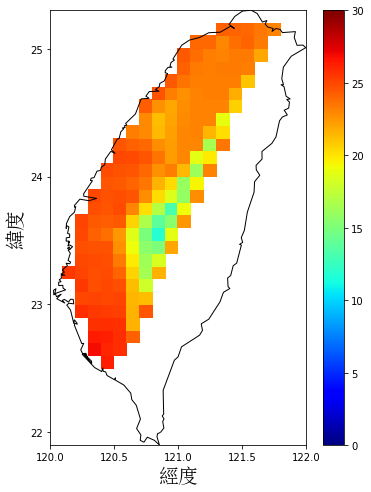

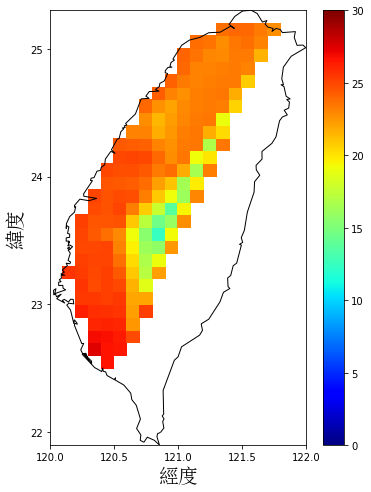

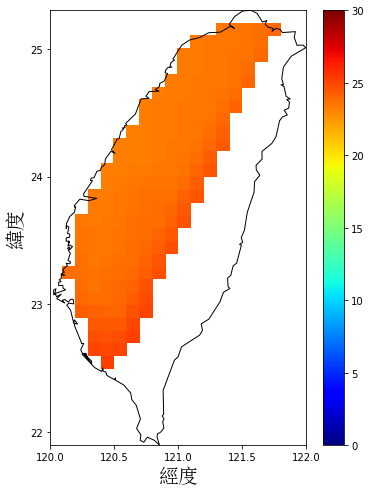

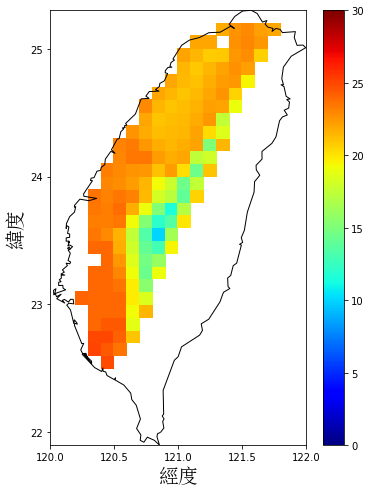

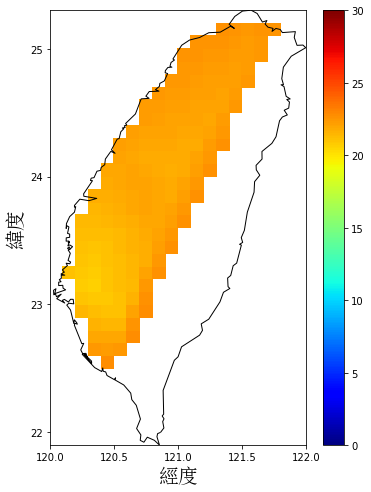

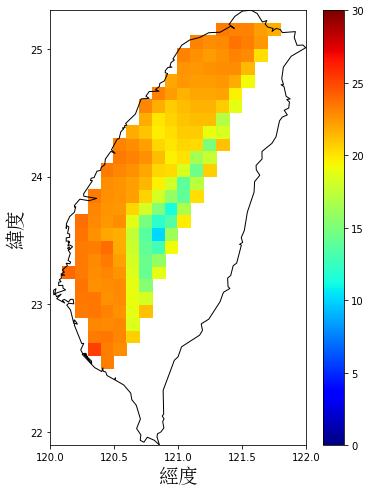

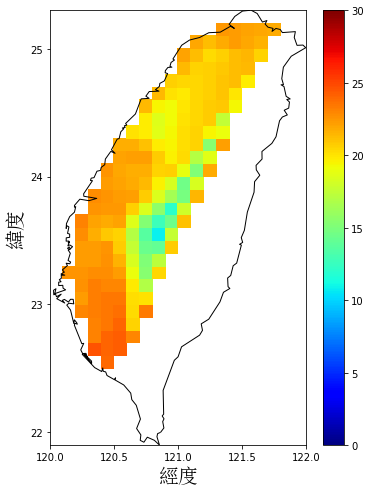

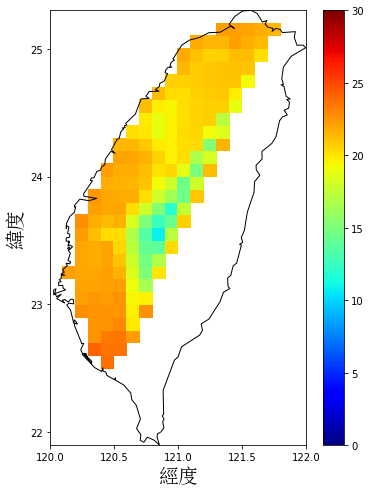

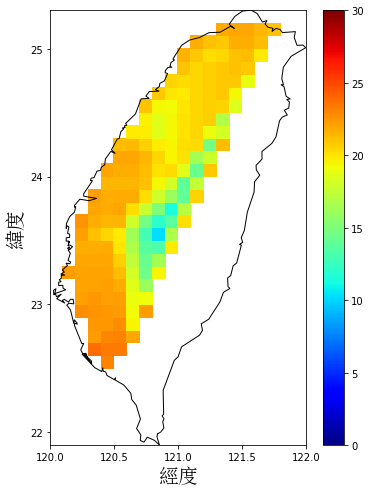

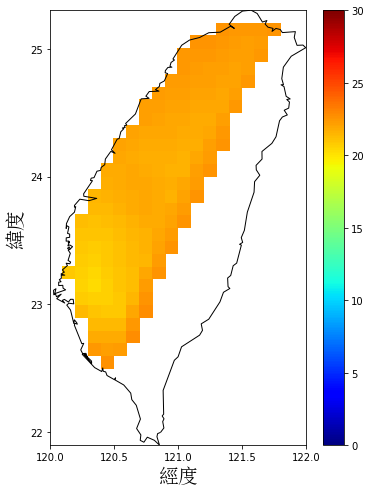

In [44]:
for i in range(23):
    Plot_temp(test_temp_obs, i, 0, title = str('觀測溫度'), save_name = str(int(test_time_index[i][0]))+'obs')
    Plot_temp(test_temp_forecast_interp.reshape(n_test, n_day*n_hour, -1), i, 0, title = str('預測溫度(原預測)'), save_name = str(int(test_time_index[i][0]))+'forecast')
    Plot_temp(temp_pred.reshape(n_test, n_day*n_hour, -1), i, 0, title = str('預測溫度(模型一)'), save_name = str(int(test_time_index[i][0]))+'model1')
    Plot_temp(temp_pred2.reshape(n_test, n_day*n_hour, -1), i, 0, title = str('預測溫度(模型二d=7)'), save_name = str(int(test_time_index[i][0]))+'model2(d=7)')
    Plot_temp(temp_pred3.reshape(n_test, n_day*n_hour, -1), i, 0, title = str('預測溫度(模型二d=14)'), save_name = str(int(test_time_index[i][0]))+'model2(d=14)')
    Plot_temp(temp_pred4.reshape(n_test, n_day*n_hour, -1), i, 0, title = str('預測溫度(模型二d=21)'), save_name = str(int(test_time_index[i][0]))+'model2(d=21)')
    Plot_temp(temp_pred_lm.reshape(n_test, n_day*n_hour, -1), i, 0, title = str('預測溫度(模型三)'), save_name = str(int(test_time_index[i][0]))+'model3')

In [ ]:
def Make_Animation(temp, fun, title, n_day = 7):
    fig = plt.figure(figsize = (6, 8))
    lat = np.arange(21.9, 25.3, 0.1)
    lon = np.arange(120, 122, 0.1)
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    map1 = Basemap(llcrnrlon = 120, llcrnrlat = 21.9, urcrnrlon = 122, urcrnrlat = 25.3, 
                   resolution = 'i', lat_0 = 23.5, lon_0 = 120.5)
    x, y = map1(lon_grid, lat_grid)
    ims = []
    for i in range(n_day*24):
        temp_grid = sp.interpolate.griddata(grid_obs, temp[fun][i], (lat_grid, lon_grid), method = 'linear') - 273.15
        m = np.ma.masked_where(np.isnan(temp_grid), temp_grid)    
        ims.append((map1.pcolormesh(x, y, m, vmin = 0, vmax = 30, cmap = 'jet'), ))

    map1.drawcoastlines()
    plt.xticks(np.arange(120, 122, 0.5))
    plt.yticks(np.arange(21.9, 25.3, 0.5))
    plt.colorbar()
    #plt.title(title)
    im_ani = animation.ArtistAnimation(fig, ims, interval = 400, blit = True)
    im_ani.save(title+'.mp4')

In [ ]:
pre_time = time.time()
fun = 12
n_day_ani = 1

fig = plt.figure(figsize = (24, 16))
lat = np.arange(21.9, 25.3, 0.1)
lon = np.arange(120, 122, 0.1)
lon_grid, lat_grid = np.meshgrid(lon, lat)
map1 = Basemap(llcrnrlon = 120, llcrnrlat = 21.9, urcrnrlon = 122, urcrnrlat = 25.3, 
                resolution = 'i', lat_0 = 23.5, lon_0 = 120.5)
x, y = map1(lon_grid, lat_grid)
ims = []
for i in range(n_day_ani*24):
    ax1 = fig.add_subplot(241)
    temp_grid = sp.interpolate.griddata(grid_obs, test_temp_obs[fun][i], (lat_grid, lon_grid), method = 'linear') - 273.15
    m = np.ma.masked_where(np.isnan(temp_grid), temp_grid)
    im1 = map1.pcolormesh(x, y, m, vmin = 0, vmax = 30, cmap = 'jet')
    
    ax2 = fig.add_subplot(242)
    temp_grid = sp.interpolate.griddata(grid_obs, test_temp_forecast_interp.reshape(n_test, n_day*n_hour, -1)[fun][i], (lat_grid, lon_grid), method = 'linear') - 273.15
    m = np.ma.masked_where(np.isnan(temp_grid), temp_grid)
    im2 = map1.pcolormesh(x, y, m, vmin = 0, vmax = 30, cmap = 'jet')
    
    ax3 = fig.add_subplot(243)
    temp_grid = sp.interpolate.griddata(grid_obs, temp_pred.reshape(n_test, n_day*n_hour, -1)[fun][i], (lat_grid, lon_grid), method = 'linear') - 273.15
    m = np.ma.masked_where(np.isnan(temp_grid), temp_grid)
    im3 = map1.pcolormesh(x, y, m, vmin = 0, vmax = 30, cmap = 'jet')
    
    ax4 = fig.add_subplot(244)
    temp_grid = sp.interpolate.griddata(grid_obs, temp_pred_lm.reshape(n_test, n_day*n_hour, -1)[fun][i], (lat_grid, lon_grid), method = 'linear') - 273.15
    m = np.ma.masked_where(np.isnan(temp_grid), temp_grid)
    im4 = map1.pcolormesh(x, y, m, vmin = 0, vmax = 30, cmap = 'jet')
    
    ax5 = fig.add_subplot(245)
    temp_grid = sp.interpolate.griddata(grid_obs, temp_pred2.reshape(n_test, n_day*n_hour, -1)[fun][i], (lat_grid, lon_grid), method = 'linear') - 273.15
    m = np.ma.masked_where(np.isnan(temp_grid), temp_grid)
    im5 = map1.pcolormesh(x, y, m, vmin = 0, vmax = 30, cmap = 'jet')
    
    ax6 = fig.add_subplot(246)
    temp_grid = sp.interpolate.griddata(grid_obs, temp_pred3.reshape(n_test, n_day*n_hour, -1)[fun][i], (lat_grid, lon_grid), method = 'linear') - 273.15
    m = np.ma.masked_where(np.isnan(temp_grid), temp_grid)
    im6 = map1.pcolormesh(x, y, m, vmin = 0, vmax = 30, cmap = 'jet')
    
    ax7 = fig.add_subplot(247)
    temp_grid = sp.interpolate.griddata(grid_obs, temp_pred4.reshape(n_test, n_day*n_hour, -1)[fun][i], (lat_grid, lon_grid), method = 'linear') - 273.15
    m = np.ma.masked_where(np.isnan(temp_grid), temp_grid)
    im7 = map1.pcolormesh(x, y, m, vmin = 0, vmax = 30, cmap = 'jet')
    
    ax8 = fig.add_subplot(248)
    temp_grid = sp.interpolate.griddata(grid_obs, temp_pred5.reshape(n_test, n_day*n_hour, -1)[fun][i], (lat_grid, lon_grid), method = 'linear') - 273.15
    m = np.ma.masked_where(np.isnan(temp_grid), temp_grid)
    im8 = map1.pcolormesh(x, y, m, vmin = 0, vmax = 30, cmap = 'jet')
    
    ims.append(([im1, im2, im3, im4, im5, im6, im7, im8]))


plt.subplot(241)
map1.drawcoastlines()
plt.xticks(np.arange(120, 122, 0.5))
plt.yticks(np.arange(21.9, 25.3, 0.5))
plt.title('Observe')
plt.colorbar()

plt.subplot(242)
map1.drawcoastlines()
plt.xticks(np.arange(120, 122, 0.5))
plt.yticks(np.arange(21.9, 25.3, 0.5))
plt.title('Forecast')
plt.colorbar()

plt.subplot(243)
map1.drawcoastlines()
plt.xticks(np.arange(120, 122, 0.5))
plt.yticks(np.arange(21.9, 25.3, 0.5))
plt.title('Model1')
plt.colorbar()

plt.subplot(244)
map1.drawcoastlines()
plt.xticks(np.arange(120, 122, 0.5))
plt.yticks(np.arange(21.9, 25.3, 0.5))
plt.title('Gel et al.')
plt.colorbar()

plt.subplot(245)
map1.drawcoastlines()
plt.xticks(np.arange(120, 122, 0.5))
plt.yticks(np.arange(21.9, 25.3, 0.5))
plt.title('Model2(d=7)')
plt.colorbar()

plt.subplot(246)
map1.drawcoastlines()
plt.xticks(np.arange(120, 122, 0.5))
plt.yticks(np.arange(21.9, 25.3, 0.5))
plt.title('Model2(d=14)')
plt.colorbar()

plt.subplot(247)
map1.drawcoastlines()
plt.xticks(np.arange(120, 122, 0.5))
plt.yticks(np.arange(21.9, 25.3, 0.5))
plt.title('Model2(d=21)')
plt.colorbar()

plt.subplot(248)
map1.drawcoastlines()
plt.xticks(np.arange(120, 122, 0.5))
plt.yticks(np.arange(21.9, 25.3, 0.5))
plt.title('Model2(d=45)')
plt.colorbar()

im_ani = animation.ArtistAnimation(fig, ims, interval = 1200, blit = True)
im_ani.save('20160112.mp4')
time.time() - pre_time

In [ ]:
test_time_index

In [ ]:
temp_pred.shape, test_temp_forecast_interp.shape

In [ ]:
Make_Animation(test_temp_obs, 12, title = '20160112obs')
Make_Animation(temp_pred.reshape(n_test, n_day*n_hour, -1), 12, title = '20160112model1')

In [ ]:
#test

k = 6
for i in range(grid_obs.shape[0])[:10]:        
    fig = plt.figure(figsize = (15, 5))
    plt.plot(np.unique(t_obs[:, 0]), test_temp_obs[k][:, i]-273.15, label = 'observe')
    plt.plot(np.unique(t_obs[:, 0]), temp_pred.reshape(n_test, n_day*n_hour, n_grid_obs)[k][:, i]-273.15, 'r', label = 'CE')
    plt.plot(np.unique(t_obs[:, 0]), test_temp_forecast_interp.reshape(n_test, n_day*n_hour, n_grid_obs)[k][:, i]-273.15, 'b', label = 'forecast')
    plt.plot(np.unique(t_obs[:, 0]), temp_pred_lm.reshape(n_test, n_day*n_hour, n_grid_obs)[k][:, i]-273.15, 'g', label = 'linear model')
    plt.plot(np.unique(t_obs[:, 0]), temp_pred2.reshape(n_test, n_day*n_hour, n_grid_obs)[k][:, i]-273.15, 'm', label = 'CE(2 covariates)')
    plt.xticks(np.arange(n_day+2))
    plt.xlabel('time')
    plt.ylabel('temperature')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(location_name[np.where((location_name[:, :2].astype(float) == grid_obs[i]).all(axis = 1)), 2][0][0], fontproperties=font)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1, 1), loc = 2)
    plt.show()

In [ ]:
#test

k = 2
for i in range(grid_obs.shape[0])[:10]:        
    fig = plt.figure(figsize = (15, 5))
    plt.plot(np.unique(t_obs[:, 0]), test_temp_obs[k][:, i]-273.15, label = 'observe')
    plt.plot(np.unique(t_obs[:, 0]), temp_pred.reshape(n_test, n_day*n_hour, n_grid_obs)[k][:, i]-273.15, 'r', label = 'CE')
    plt.plot(np.unique(t_obs[:, 0]), test_temp_forecast_interp.reshape(n_test, n_day*n_hour, n_grid_obs)[k][:, i]-273.15, 'b', label = 'forecast')
    plt.plot(np.unique(t_obs[:, 0]), temp_pred_lm.reshape(n_test, n_day*n_hour, n_grid_obs)[k][:, i]-273.15, 'g', label = 'linear model')
    plt.plot(np.unique(t_obs[:, 0]), temp_pred2.reshape(n_test, n_day*n_hour, n_grid_obs)[k][:, i]-273.15, 'm', label = 'CE(2 covariates)')
    plt.xticks(np.arange(n_day+2))
    plt.xlabel('time')
    plt.ylabel('temperature')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(location_name[np.where((location_name[:, :2].astype(float) == grid_obs[i]).all(axis = 1)), 2][0][0], fontproperties=font)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1, 1), loc = 2)
    plt.show()

In [ ]:
test_time_index[6], test_time_index[2]

In [ ]:
#conditional expectation to predict 45 days temperature(train)

pre_time = time.time()
temp_pred_train = Conditional_Expectation(temp_forecast,
                                          temp_obs_fit.reshape(n_fn, -1), 
                                          temp_forecast)
time.time() - pre_time

In [ ]:
mean_daily_AE_train, sd_daily_AE_train = Predict_Error(temp_pred_train, temp_obs.reshape(n_fn, -1))
mean_daily_AE_forecast_train, sd_daily_AE_forecast_train = Predict_Error(temp_forecast_interp, temp_obs.reshape(n_fn, -1))

In [ ]:
#daily_AE_train

mean_daily_AE_train, sd_daily_AE_train

In [ ]:
#daily_AE_forecast_train

mean_daily_AE_forecast_train, sd_daily_AE_forecast_train